In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone
import vaex

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics
from utils.data import get_events, get_sections, load_df, process_df, export_dataframe_to_latex
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

Train size ≃ 27.23%
Test size ≃ 72.77%


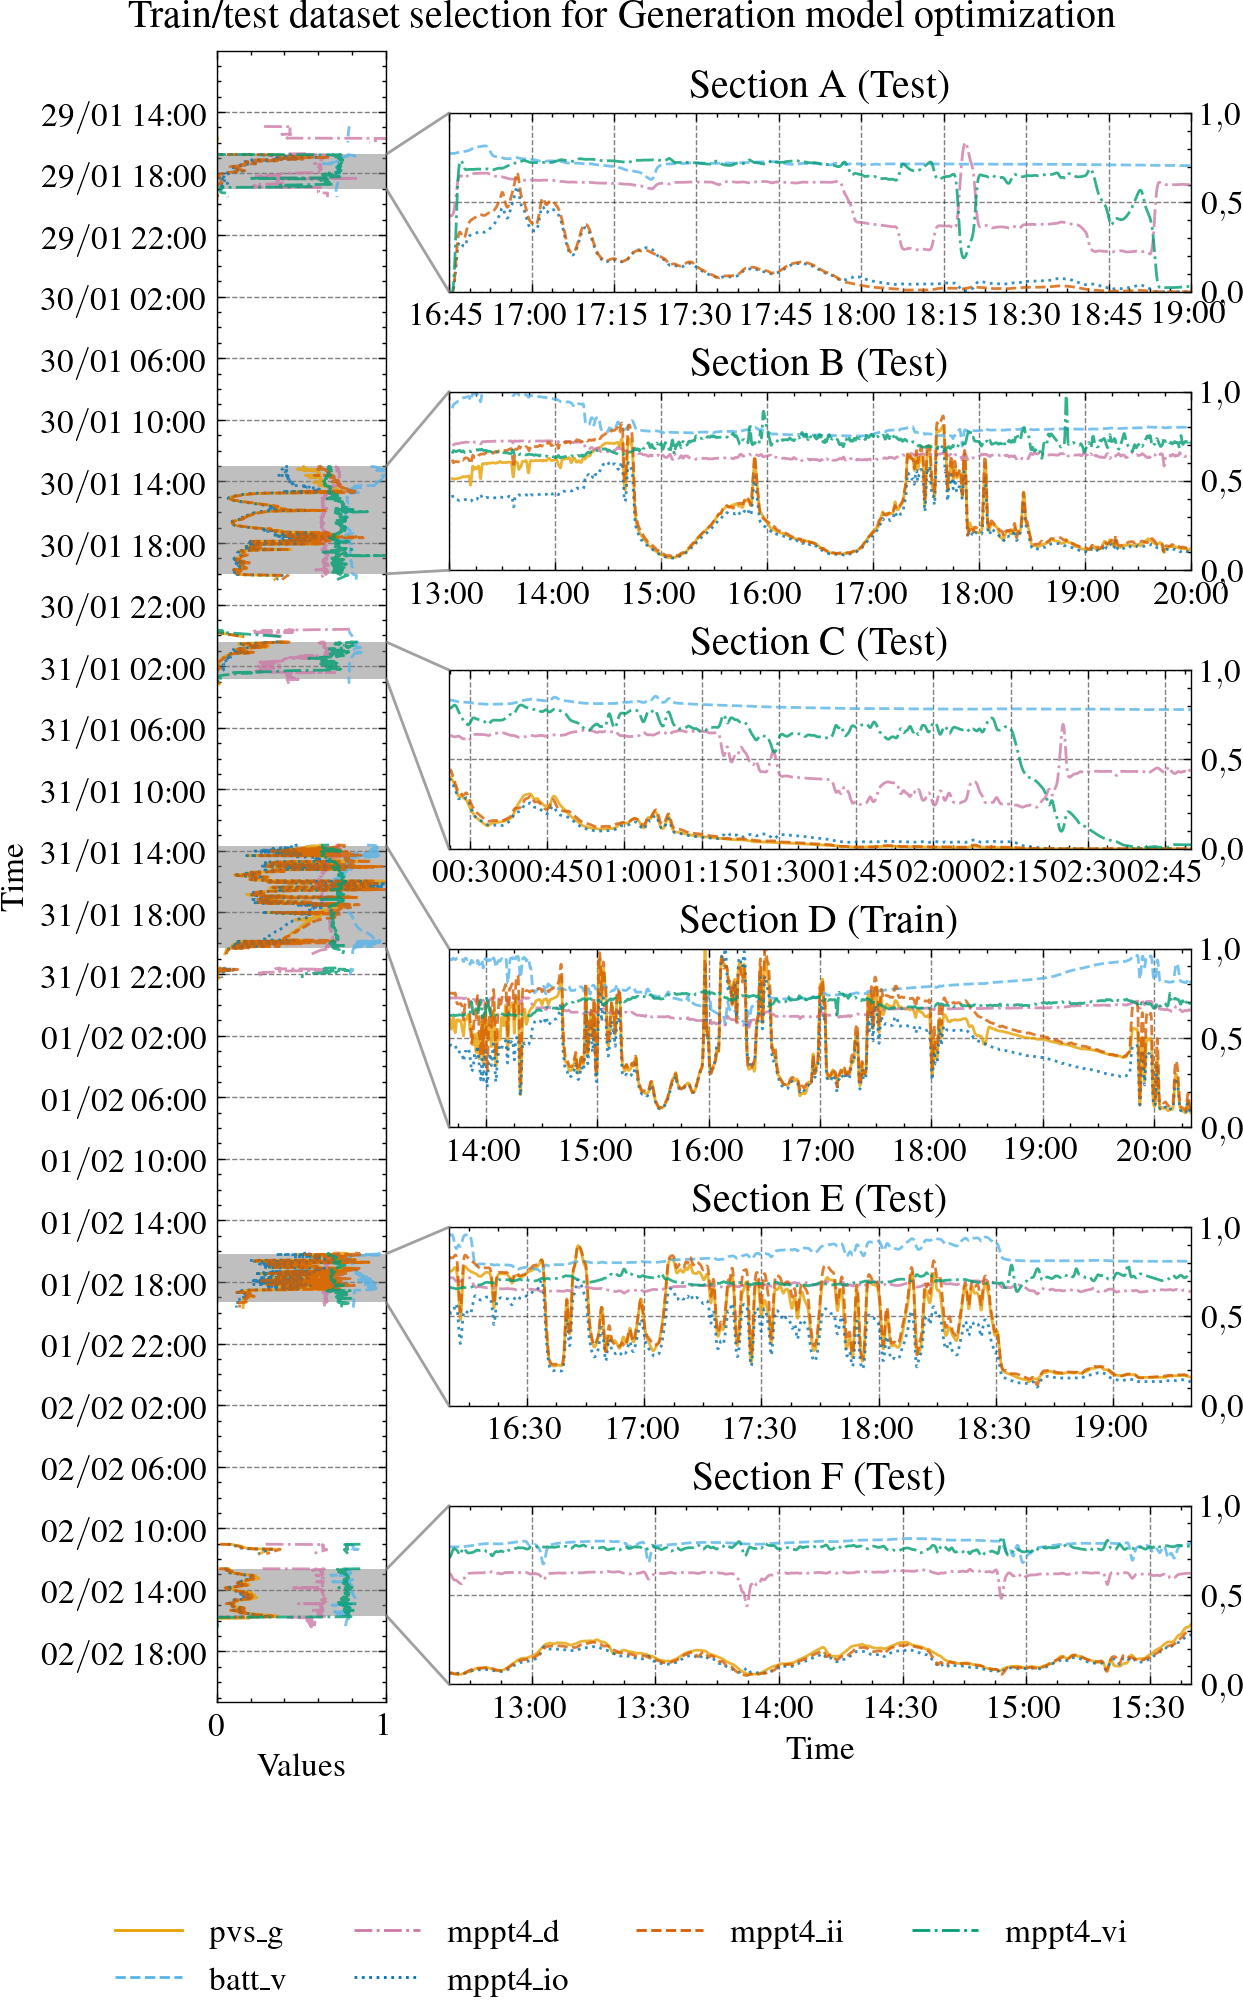

In [2]:
from fractions import Fraction

filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    # 'Battery Current': 'batt_i',
    # 'ESC Duty Cycle': 'esc_d',
    # 'Motor Angular Speed': 'motor_w',
    # 'ESC Input Power': 'esc_p_in',
    # 'ESC Input Current': 'esc_i_in',
    **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,5)},
    **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,5)},
    **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,5)},
    **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,5)},
    # 'MPPTs Output Current': 'mppts_i_out',
    'PVs G': 'pv_g',
    'Solar POA': 'solar_poa',
    # 'Wind Speed': 'wind_v',
    # 'Air Temperature': 'air_t',
}

df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule='1s',
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=0.5,
    cutoff_freq=1/100,
    sampling_rate=1,
    order=2,
)

sections, tzinfo = get_sections()
train_section_name = 'Section D'
train_test_sections = sections.reset_index().to_dict(orient='records')
train_section = sections.loc[sections.index == train_section_name].reset_index().to_dict(orient='records')[0]
test_sections = sections.loc[sections.index != train_section_name].reset_index().to_dict(orient='records')

train_size = 0
test_size = 0
for i in range(len(train_test_sections)):
    if train_test_sections[i]['name'] == train_section_name:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Train)'
        train_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size
    else:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Test)'
        test_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size


total_size = train_size+test_size
print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
        filename=None,#f'{latex_img_path}/generation_optimization_test_residuals_{col}.pdf',
        show_title=f'Train/test dataset selection for Generation model optimization',
        save_title=f'Dataset da embarcação durante o DSB de 2019',
        ncol=4,
        fig=plot_events_data(
            events=train_test_sections,
            df=df,
            column_names=["pv_g", "batt_v", 'mppt4_d', 'mppt4_io', 'mppt4_ii', 'mppt4_vi'],
            normalize=True,
        )
    )


# Generation System model

In [3]:
import control as ct

class Generation:
    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        pass

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Params
        pv_S, pv_eta, mppt_eta = (
            params['pv_S'],
            params['pv_eta'],
            params['mppt_eta'],
        )

        # Inputs
        pv_g = u[0]  # Total incident irradiance [W/m^2]
        batt_v = u[1]  # Battery voltage [V]
        mppt_d = u[2]  # MPPT Duty Cycle


        # Output equations
        pv_p_out = pv_g*pv_S*pv_eta
        mppt_i_out = mppt_eta*pv_p_out/batt_v
        mppt_i_in = mppt_i_out * (mppt_d / (1 - mppt_d))
        mppt_v_in = pv_p_out / mppt_i_in

        return np.array([mppt_i_out, mppt_i_in, mppt_v_in])


    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name='generation',
            states=None,
            inputs=('pv_g', 'batt_v', 'mppt4_d'),
            outputs=('mppt4_io', 'mppt4_ii', 'mppt4_vi'),
            params=params,
        )


Generation.build({})

<NonlinearIOSystem:generation:['pv_g', 'batt_v', 'mppt4_d']->['mppt4_io', 'mppt4_ii', 'mppt4_vi']>

In [4]:
generation_params = {
    'pv_S': 1.650 * 0.992,
    'pv_eta': 0.1588,
    'mppt_eta': 0.9259,
    'mppts_n': 4,
}

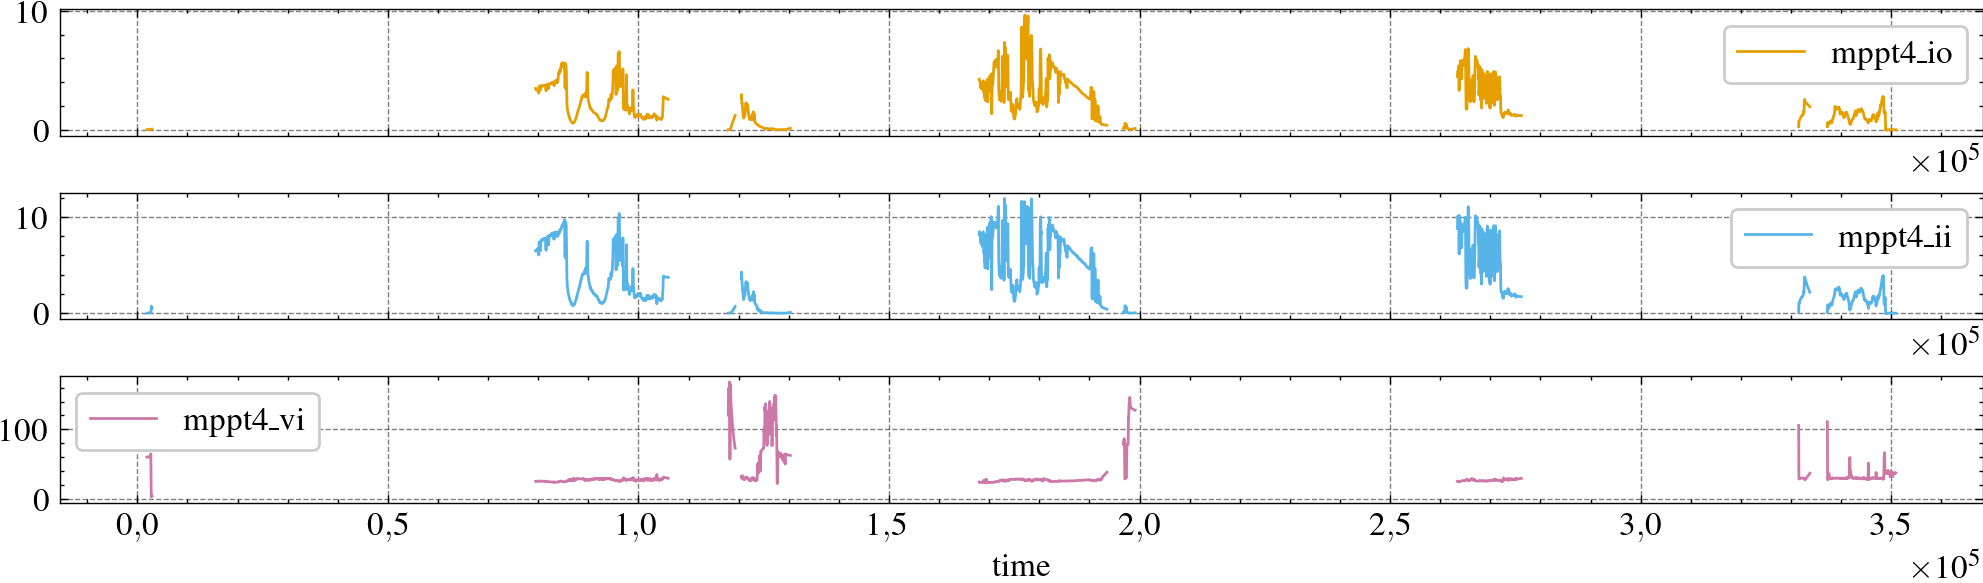

In [5]:
# Time array
T = df['t'].to_numpy()

# Inputs
U = df[['pv_g', 'batt_v', 'mppt4_d']].to_numpy().T

# Model
generation = Generation.build(generation_params)

# Initial state
X0 = np.zeros(generation.nstates)
# X0[generation.state_index['']] = 1

# Simulation
res = ct.input_output_response(generation, T=T, U=U, X0=X0, solve_ivp_method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]

ydata.plot(subplots=True, figsize=(10,3))
plt.show()

## Sensitivity Analysis

In [6]:
def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Generation.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

def generation_sensitivity_analysis_step_response(
    params_description: dict,
    poa_step: float,
    voltage_step: float,
    duty_cycle_step: float,
    samples: int,
    do_plot=True,
):

    model_class = Generation
    model_params = generation_params
    model_tmp = model_class.build(model_params)

    # Time array
    T = np.linspace(0, 10, 11, endpoint=True)

    # Initial state
    X0 = np.zeros(model_tmp.nstates)

    # Input data
    U = np.empty([model_tmp.ninputs, len(T)]) * np.nan # nan to force us to define every input
    U[model_tmp.input_labels.index('pv_g')] = poa_step
    U[model_tmp.input_labels.index('batt_v')] = voltage_step
    U[model_tmp.input_labels.index('mppt4_d')] = duty_cycle_step

    df_sa, problem = sobol_sensitivity_analysis_from_model_params_to_outputs(
        params_description=params_description,
        T=T,
        U=U,
        X0=X0,
        model_function=model_function,
        model_class=model_class,
        model_params=model_params,
        samples=samples,
        calc_second_order=True,
        seed=42,
        nprocs=32,
    )

    df_steady_state_mean = get_region_mean(df_sa, t_start=8, t_end=10)

    export_dataframe_to_latex(
        filename=f"{latex_tex_path}/generation_sensitivity_analysis.tex",
        label=f'table:generation_sensitivity_analysis',
        caption='Índices de Sobol em regime permanente',
        df_steady_state_mean=df_steady_state_mean,
    )

    if do_plot:
        display(df_steady_state_mean)

        # fig_save_and_show(
        #     None,
        #     'Distribuição dos valores para cada fator',
        #     'Distribution of the values for each factor',
        #     fig=plot_sampled_distribuitions(problem),
        #     ncols=3,
        # )

        # for output in df_sa['output'].unique():
        #     fig_save_and_show(
        #         None,
        #         f'Índices de Sobol para a saída {output} durante o tempo',
        #         f'Sobol Indices for the output {output} over time\nwith step of {poa_step} [W/m²] and {voltage_step} [V],\nwith {samples} samples',
        #         fig=plot_sensitivity_analysis(df_sa, output=output),
        #         ncols=3,
        #     )

        # for output in df_sa['output'].unique():
        #     fig_save_and_show(
        #         None,
        #         f'Índices de Sobol para a saída {output} durante o tempo',
        #         f'Sobol Indices for the output {output} over time\nwith step of {poa_step} [W/m²] and {voltage_step} [V],\nwith {samples} samples',
        #         fig=plot_sensitivity_analysis_heatmaps(df_sa, output=output),
        #         ncols=3,
        #     )

        for output in df_sa['output'].unique():
            fig_save_and_show(
                f'{latex_img_path}/generation_sensitivity_analysis_{output}.pdf',
                f'Índices de Sobol para a saída {output} em regime permanente',
                f'Sobol Indices for the output {output} at steady-state\nwith step of {poa_step} [W/m²] and {voltage_step} [V],\nwith {samples} samples',
                fig=plot_sensitivity_analysis_bars(df_steady_state_mean, output=output),
                ncols=3,
            )

    return df_sa, problem


In [7]:
# Estimating uncertainty of efficiency measurements. The equipment used was all fluke 115 (https://www.fluke.com/en/product/electrical-testing/digital-multimeters/fluke-115)
u_v_mppt = 0.5 / 100
u_i_mppt = 1 / 100

u_p_mppt = ((u_v_mppt)**2 + (u_i_mppt)**2)**0.5
u_eta_mppt = ((u_p_mppt)**2 + (u_p_mppt)**2)**0.5

# This is from here: https://www.nrel.gov/docs/fy09osti/45299.pdf
u_pv_area = 0.63/100
u_pv_eff = 3.9/100

print(u_eta_mppt, u_pv_area, u_pv_eff)

0.015811388300841896 0.0063 0.039


pool
chain


value          conf
output   factor              metric                            
mppt4_ii pv_eta              S1      8.399416e-01  9.203971e-03
                             ST      8.400227e-01  6.613714e-03
         pv_S             S1      2.191800e-02  1.723075e-03
                             ST      2.193094e-02  2.429302e-04
         mppt_eta            S1      1.380575e-01  3.537279e-03
                             ST      1.381293e-01  1.287684e-03
         (pv_eta, mppt_eta)  S2      6.999701e-05  1.230330e-02
         (pv_S, pv_eta)   S2      1.111232e-05  3.306577e-03
         (pv_S, mppt_eta) S2      1.829140e-06  2.547467e-03
mppt4_io pv_eta              S1      8.399416e-01  9.203971e-03
                             ST      8.400227e-01  6.613714e-03
         pv_S             S1      2.191800e-02  1.723075e-03
                             ST      2.193094e-02  2.429302e-04
         mppt_eta            S1      1.380575e-01  3.537279e-03
                             ST      1.381293e-01  1.287684e-03
         (pv_eta, mppt_eta)  S2      6.999701e-05  1.230330e-02
         (pv_S, pv_eta)   S2      1.111232e-05  3.306577e-03
         (pv_S, mppt_eta) S2      1.829140e-06  2.547467e-03
mppt4_vi pv_eta              S1      7.930107e-17  9.337677e-17
                             ST      7.051143e-29  8.555317e-31
         pv_S             S1      3.204650e-17  9.198623e-17
                             ST      7.037976e-29  8.522787e-31
         mppt_eta            S1      1.000000e+00  8.621605e-03
                             ST      1.000000e+00  7.269015e-03
         (pv_eta, mppt_eta)  S2     -1.110223e-16  1.499144e-15
         (pv_S, pv_eta)   S2     -3.338638e-17  1.321136e-16
         (pv_S, mppt_eta) S2      0.000000e+00  1.402869e-15

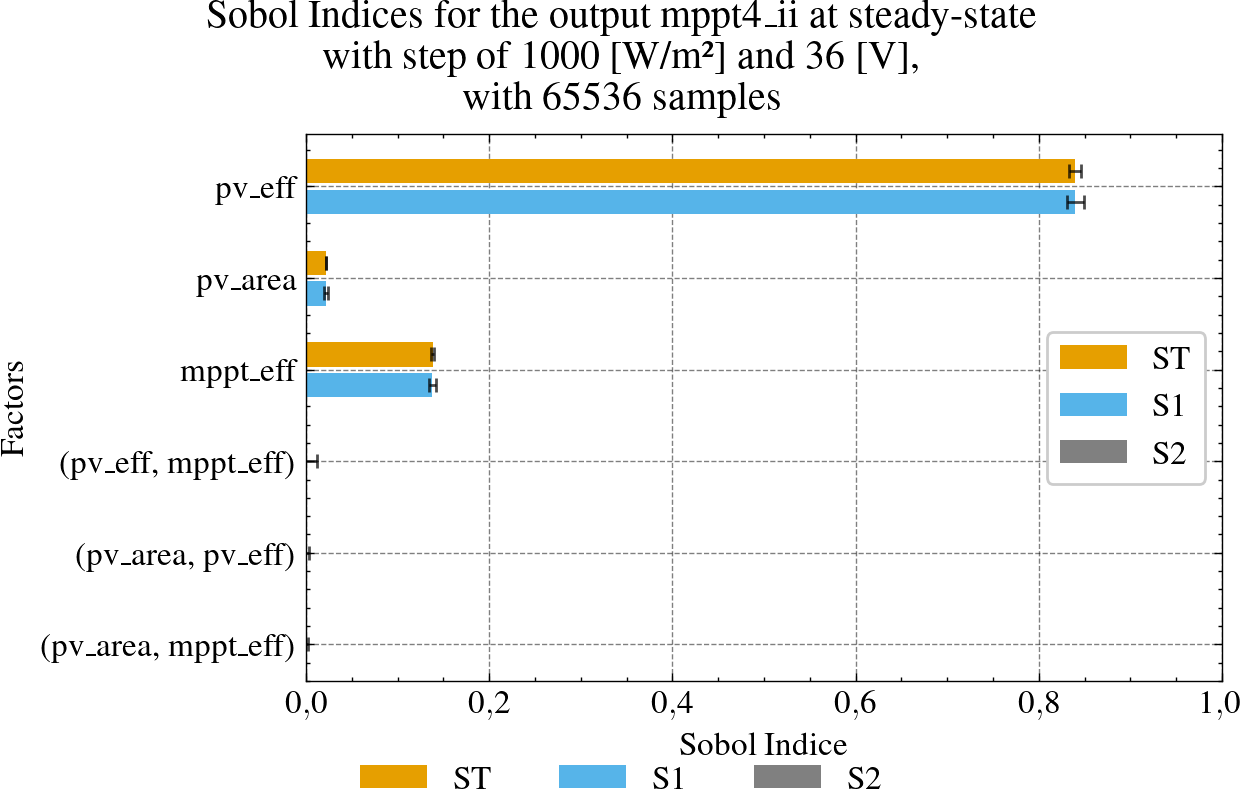

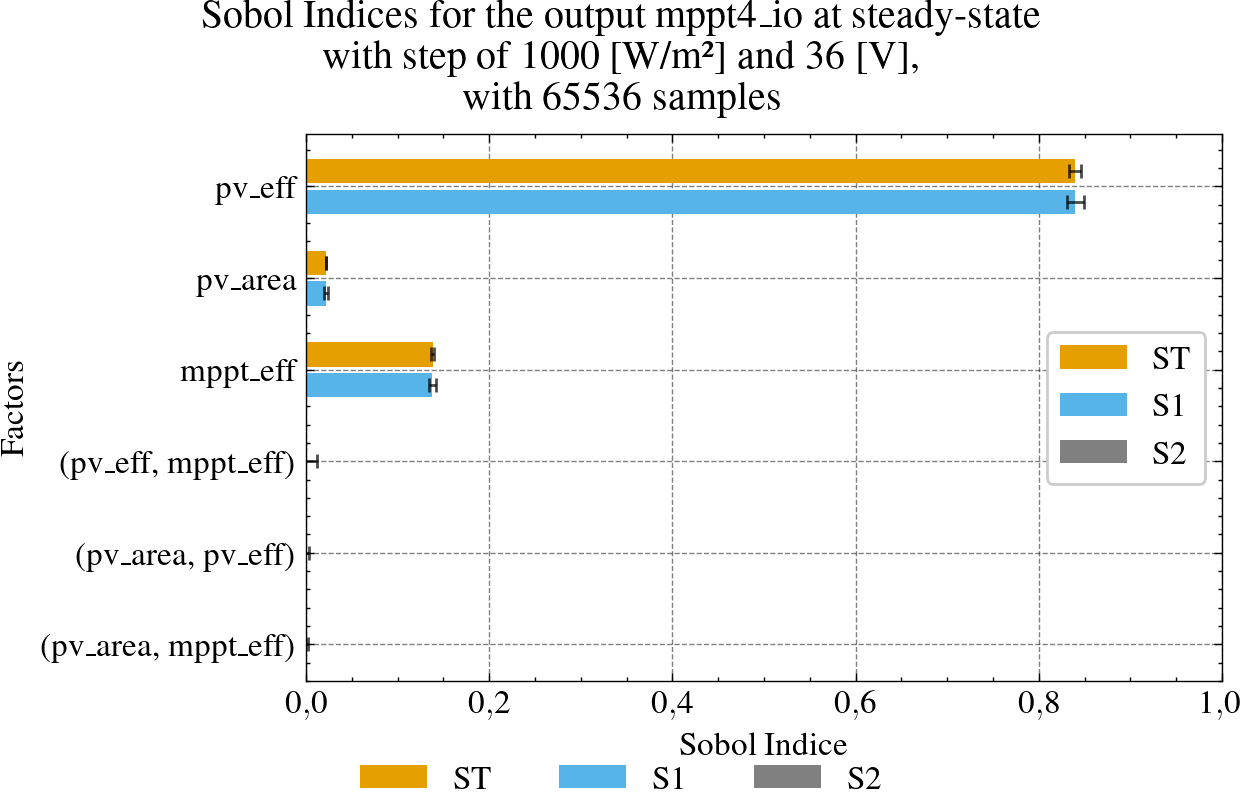

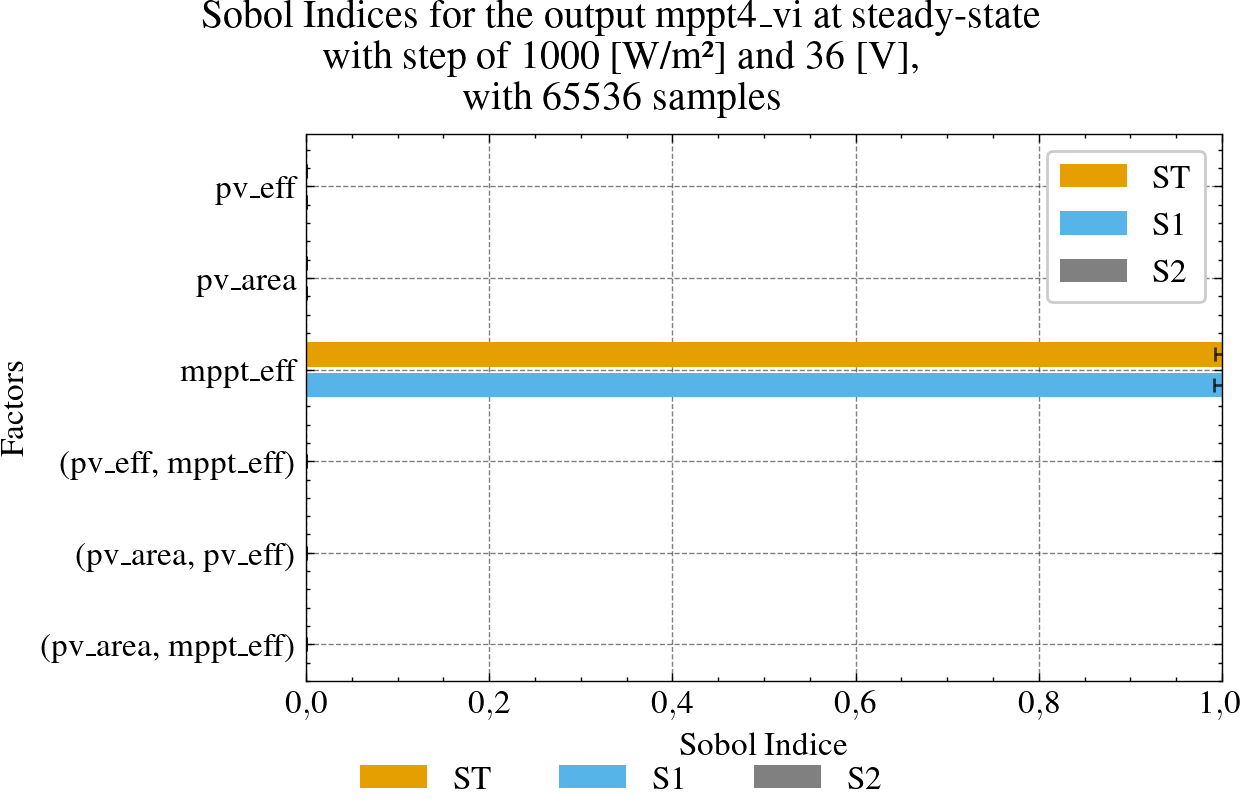

CPU times: user 3.59 s, sys: 3.23 s, total: 6.82 s
Wall time: 1min 26s


In [8]:
%%time

params_description = {
    'pv_S': describe_param_with_uniform_distribution(lower=generation_params['pv_S']*(1-u_pv_area), upper=generation_params['pv_S']*(1+u_pv_area)),
    'pv_eta': describe_param_with_uniform_distribution(lower=generation_params['pv_eta']*(1-u_pv_eff), upper=generation_params['pv_eta']*(1+u_pv_eff)),
    'mppt_eta': describe_param_with_uniform_distribution(lower=generation_params['mppt_eta']*(1-u_eta_mppt), upper=generation_params['mppt_eta']*(1+u_eta_mppt)),
}

df_sa, problem = generation_sensitivity_analysis_step_response(
    params_description=params_description,
    poa_step=1000,
    voltage_step=36,
    duty_cycle_step=0.6,
    samples=2**16,
    do_plot=True,
)


In [9]:
df_sa.head()

output  factor metric    t     value      conf
0  mppt4_ii  pv_eta     S1  0.0  0.839942  0.009204
1  mppt4_ii  pv_eta     S1  1.0  0.839942  0.009204
2  mppt4_ii  pv_eta     S1  2.0  0.839942  0.009204
3  mppt4_ii  pv_eta     S1  3.0  0.839942  0.009204
4  mppt4_ii  pv_eta     S1  4.0  0.839942  0.009204

# Optimization

In [10]:
from sklearn.preprocessing import RobustScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       20 |  2.7296811932 |  0.0450519703
     2 |       40 |  0.9751236183 |  0.0382266203
     3 |       60 |  0.3037944808 |  0.0382266203
     4 |       80 |  0.1898995186 |  0.0382266203
     5 |      100 |  0.1206784108 |  0.0332448911
     6 |      120 |  0.0844644584 |  0.0332448911
     7 |      140 |  0.0500388453 |  0.0332448911
     8 |      160 |  0.0432792649 |  0.0331838030
     9 |      180 |  0.0377521769 |  0.0331838030
    10 |      200 |  0.0356726810 |  0.0331838030
    11 |      220 |  0.0341065393 |  0.0330126958
    12 |      240 |  0.0339031588 |  0.0330126958
    13 |      260 |  0.0337001849 |  0.0329811721
    14 |      280 |  0.0334685401 |  0.0329356041
    15 |      300 |  0.0332123402 |  0.0328834474
    16 |      320 |  0.0330410353 |  0.0328834474
    17 |      340 |  0.0329894522 |  0.0328793554
    18 |      360 |  0.0329537567 |  0.0328793554
    19 |      380 |  0.0329321452 |  0.0328793554


{'pv_eta': 0.1588, 'mppt_eta': 0.9259}

Best parameters found:


{'pv_eta': 0.15553439343946882, 'mppt_eta': 0.9169846082963471}

Objective value at solution: [0.03286608]


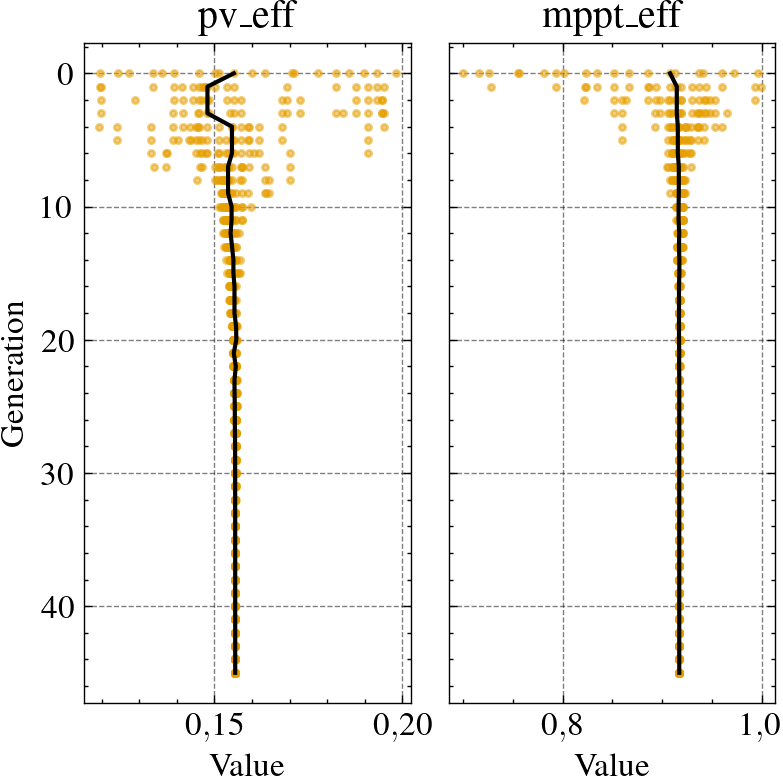

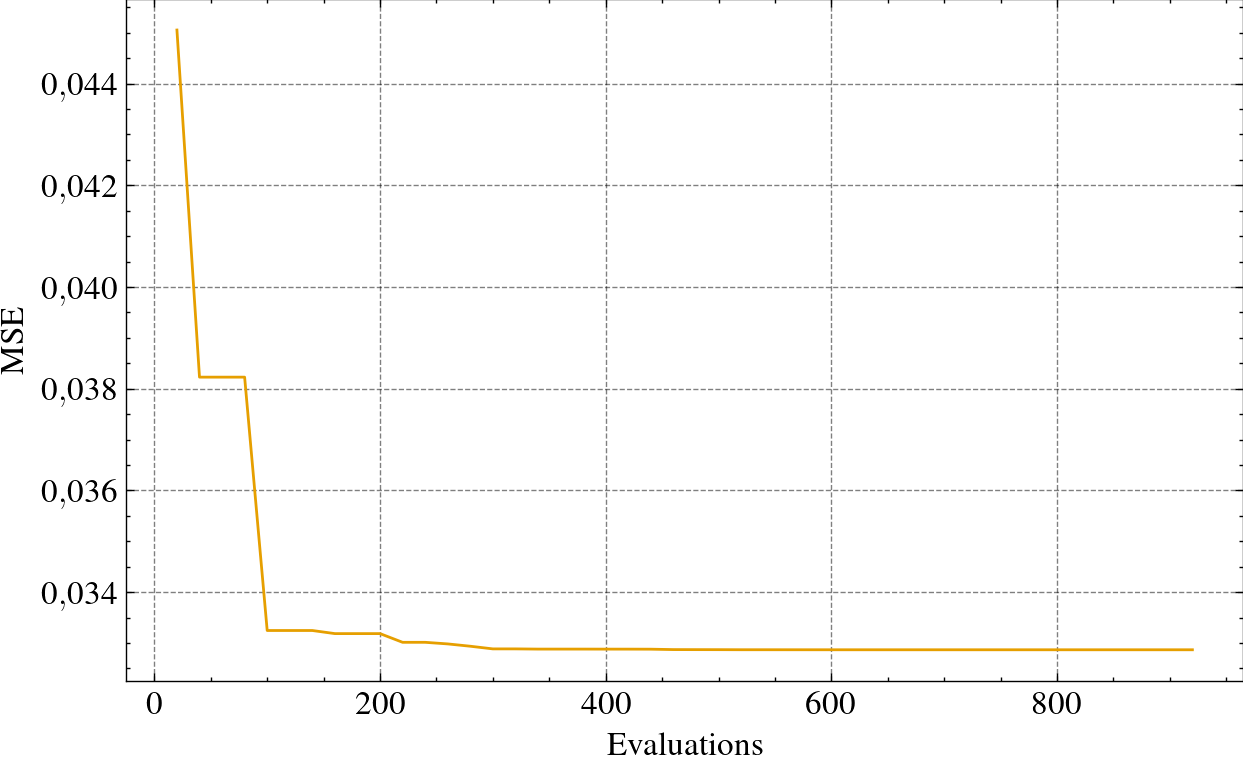

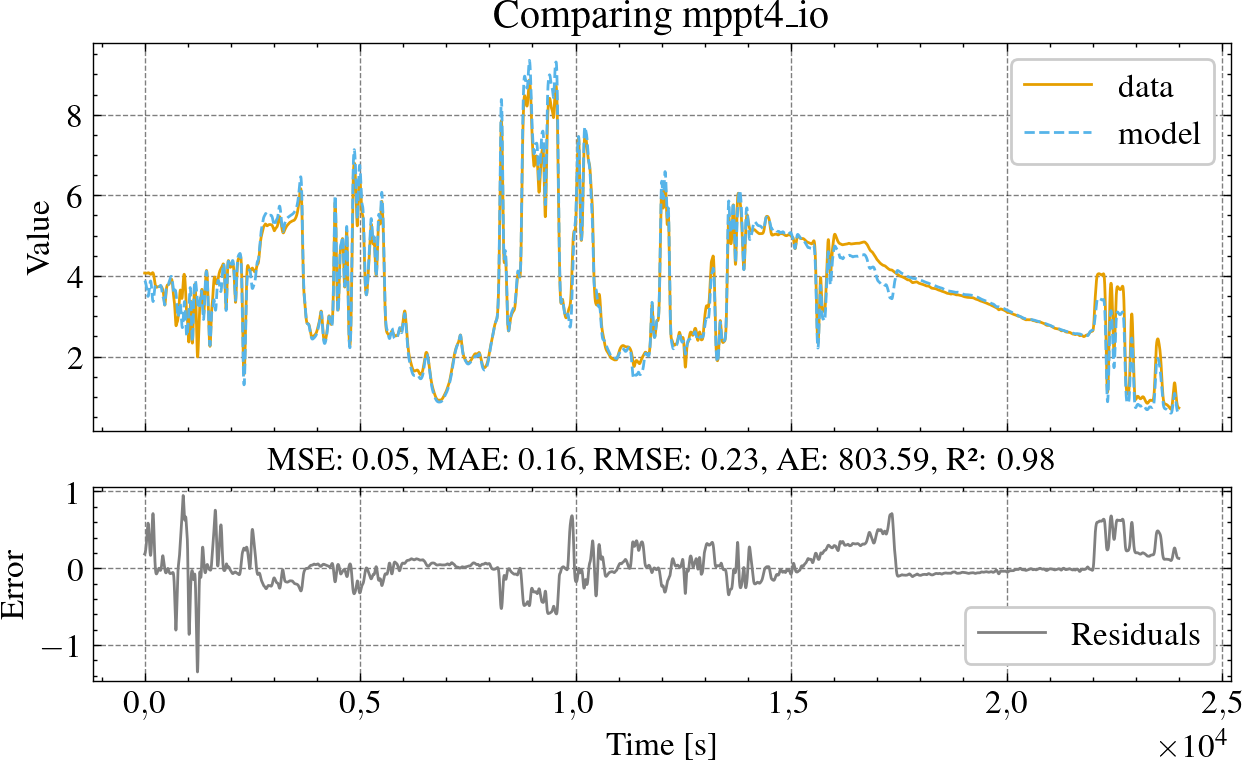

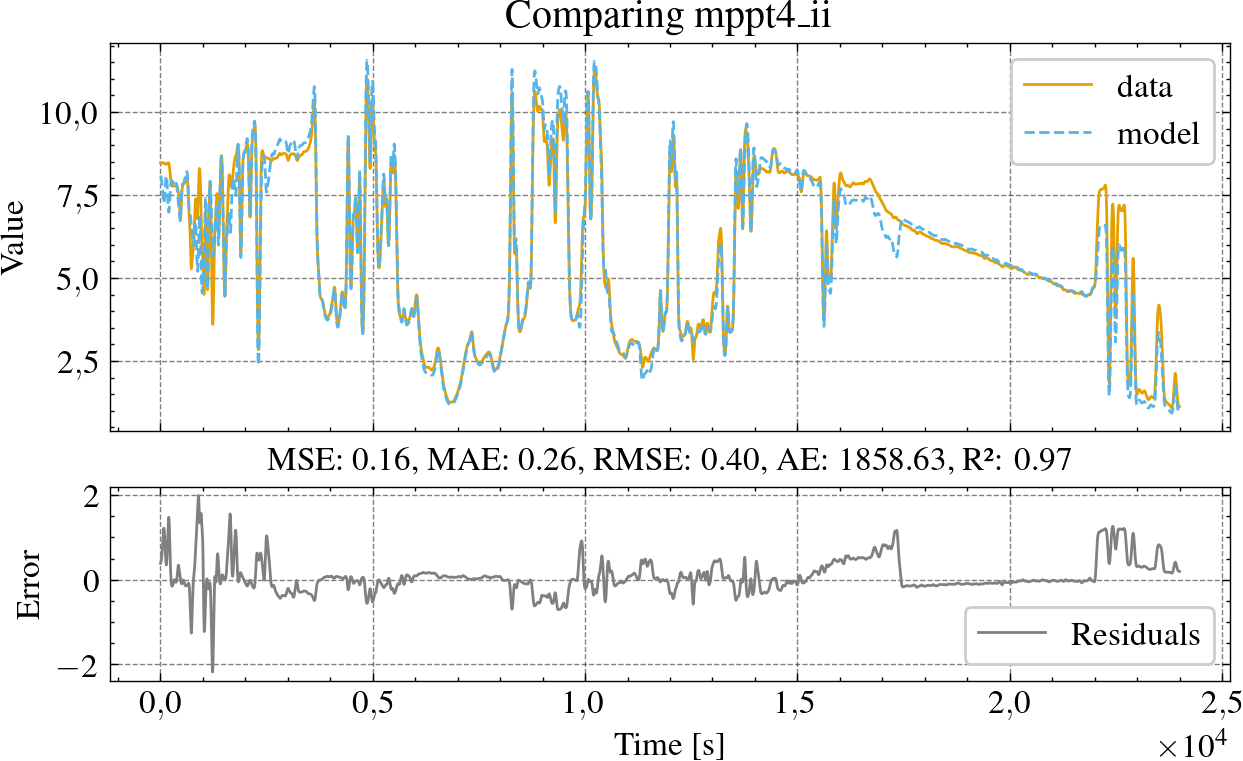

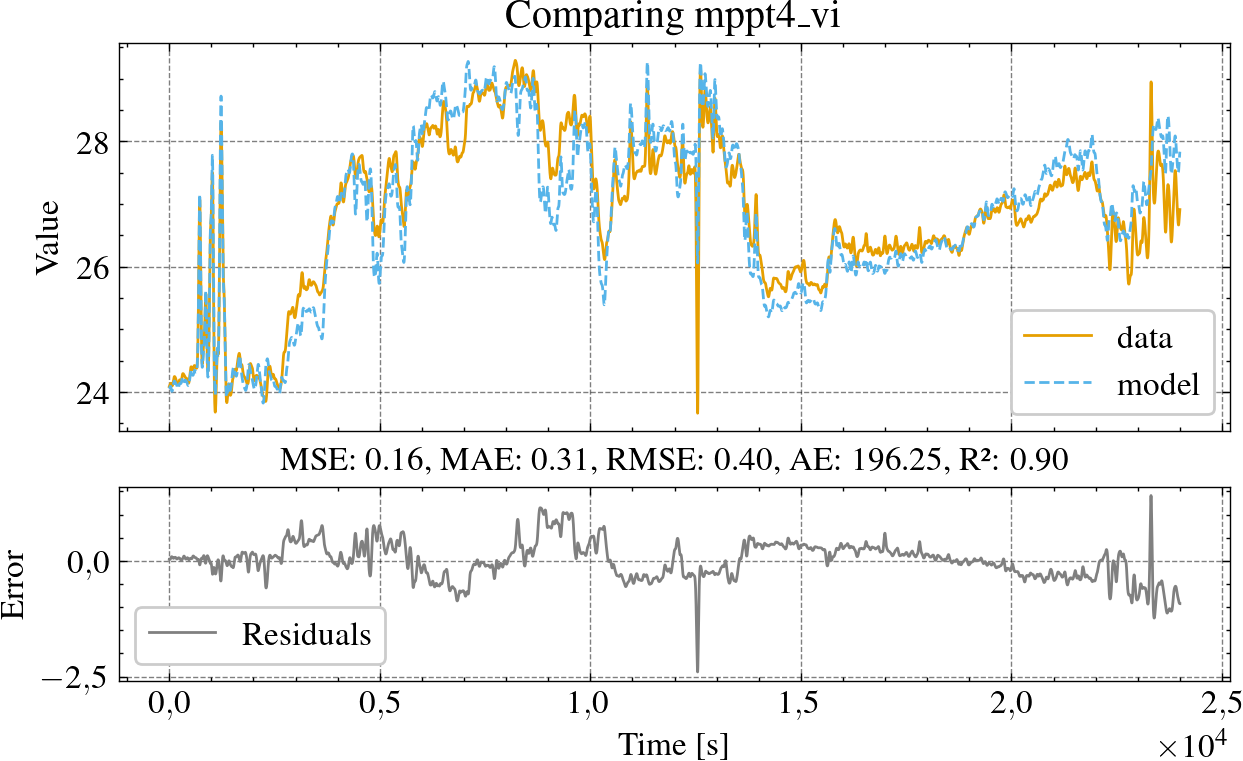

CPU times: user 4.44 s, sys: 2.6 s, total: 7.04 s
Wall time: 36.2 s


In [ ]:
%%time
## GENERATION OPTIMIZATION

# Select the optimization data
data_cols = ['mppt4_io', 'mppt4_ii', 'mppt4_vi']
input_cols = ['pv_g', 'batt_v', 'mppt4_d']

# Put simulation data into df
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols]

# Set model states initial conditions
input_initial_state = {}

# Initialize Parameters
variation = 25/100
model_params = generation_params
params_bounds = {
    'pv_eta': dict(min=max(0, model_params['pv_eta']*(1-variation)), max=min(1, model_params['pv_eta']*(1+variation))),
    'mppt_eta': dict(min=max(0, model_params['mppt_eta']*(1-variation)), max=min(1, model_params['mppt_eta']*(1+variation))),
}

# Initialize the thread pool and create the runner
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

# Initialize the problem
model = Generation
problem = MyOptimizationProblem(
    model=model,
    model_function=model_function,
    training_data=df_train,
    training_data_columns=data_cols,
    model_params=model_params,
    opt_params_bounds=params_bounds,
    input_initial_state=input_initial_state,
    input_columns=input_cols,
    data_scaler=RobustScaler,
    elementwise_runner=runner,
)

algorithm = DE(
    pop_size=10*len(params_bounds),
    sampling=LHS(),
    variant="DE/rand/1/bin",
    F=0.2,
    CR=0.9,
)

# Specify termination criteria (optional)
termination = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=20,
    n_max_gen=1000,
    n_max_evals=100000
)

# Run the optimization
result = minimize(
    problem,
    algorithm,
    termination=termination,
    seed=42,
    verbose=True,
    save_history=True,
)
print('Threads:', result.exec_time)
pool.close()
pool.join()

# Print the results
best_params = convert_to_model_params({k: result.X[i] for (i, k) in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

T = df_train['t'].to_numpy()
U = df_train[input_cols].to_numpy().T
X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

best_fit_data = model_function(T, U, X0, **(model_params | best_params))

for col in data_cols:
    plot_compare(df_train, best_fit_data, col)


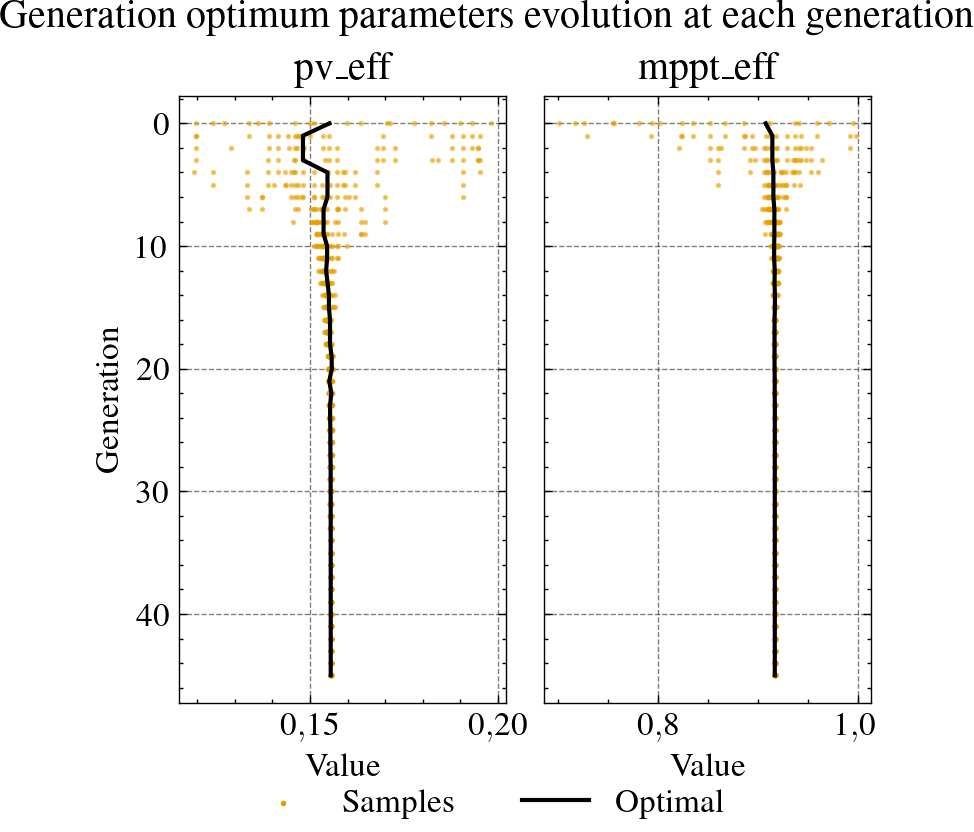

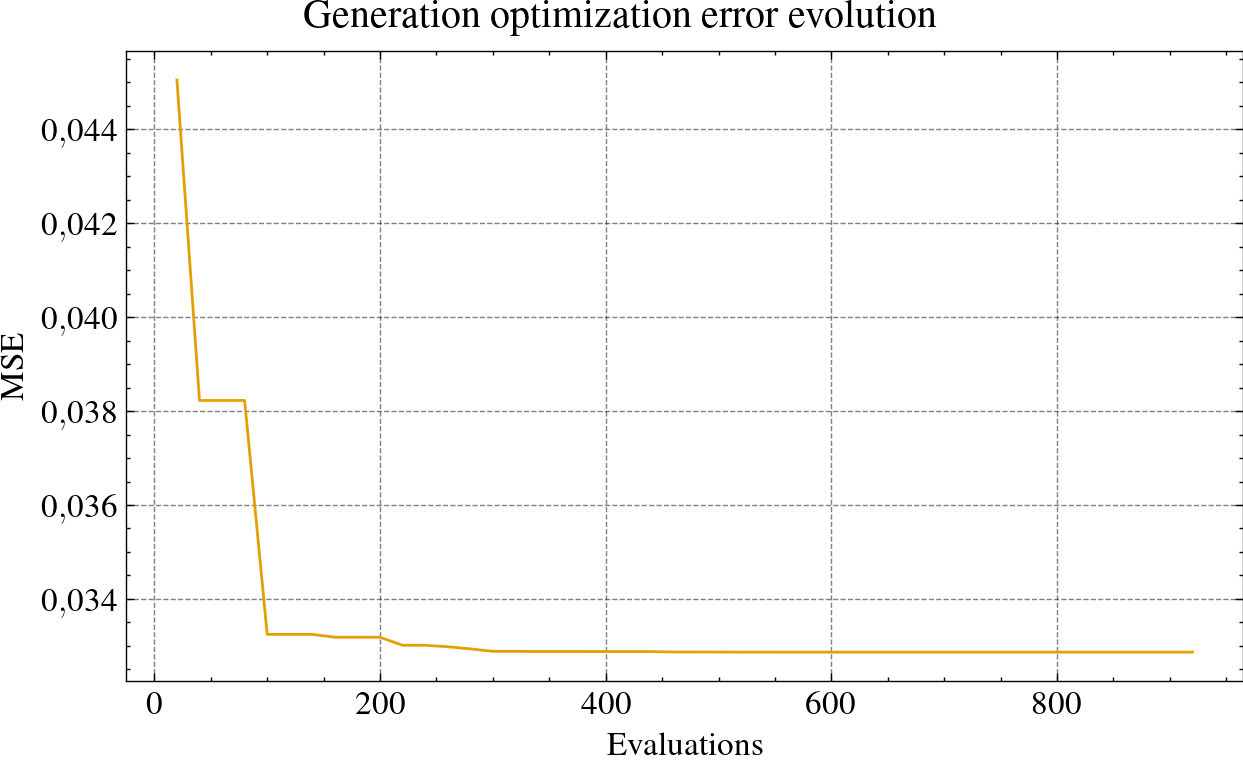

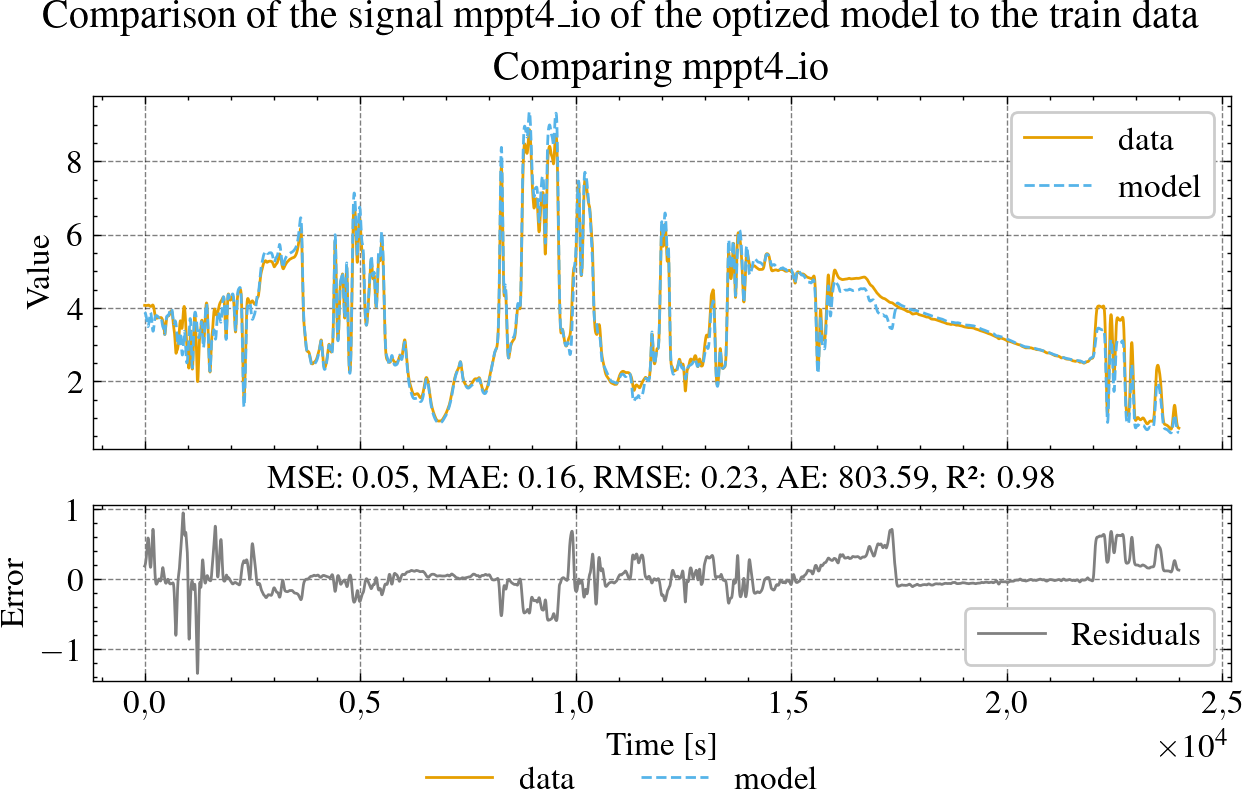

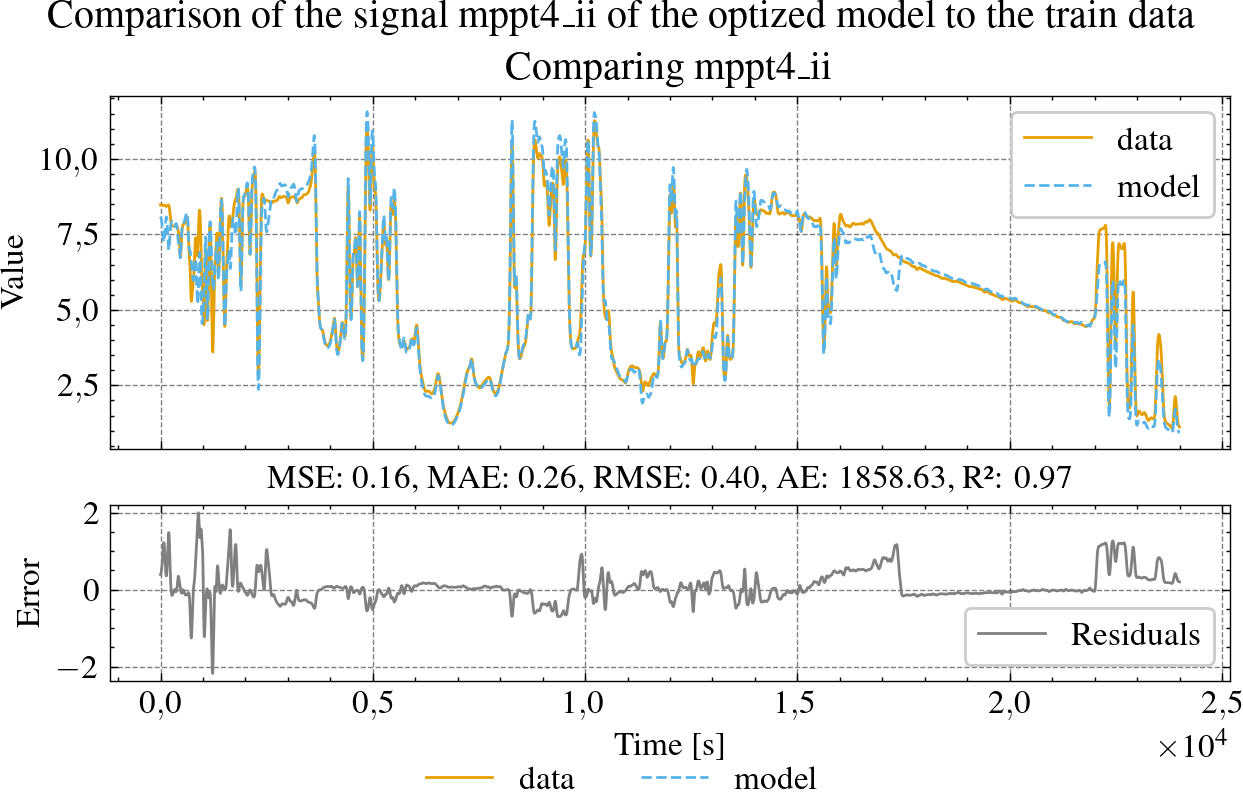

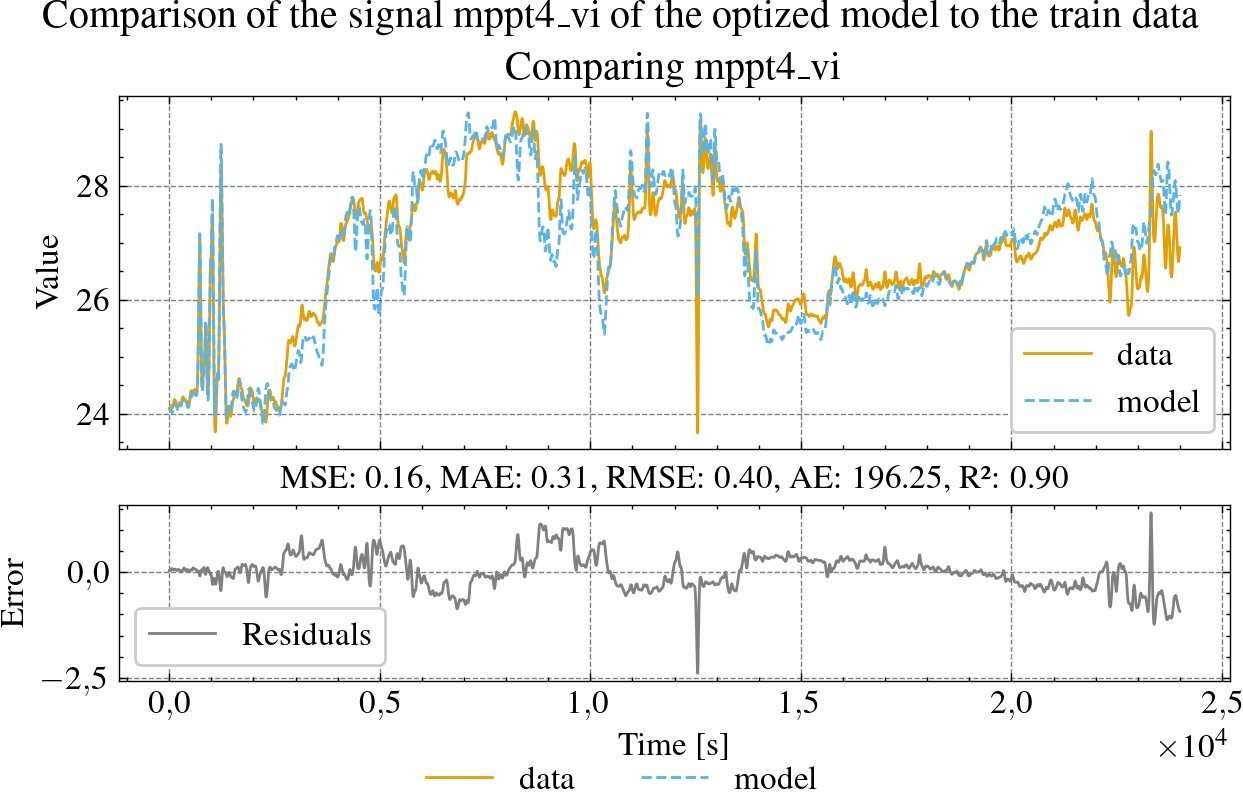

In [12]:
# Plot the original data and the fitted curve
fig_save_and_show(
    filename=f'{latex_img_path}/generation_optimization_params.pdf',
    show_title='Generation optimum parameters evolution at each generation',
    save_title='Evolução dos parâmetros ótimos do modelo PVs+MPPTs à cada geração',
    ncol=2,
    fig=plot_optimization_params(result, params_bounds=params_bounds, scatter_alpha=0.5, scatter_size=1, show=False)
)

fig_save_and_show(
    filename=f'{latex_img_path}/generation_optimization_error.pdf',
    show_title='Generation optimization error evolution',
    save_title='Evolução do erro de otimização do modelo da Geração',
    ncol=2,
    fig=plot_optimization_error(result, show=False),
)

for col in data_cols:
    fig_save_and_show(
        filename=f'{latex_img_path}/generation_optimization_residuals_{col}_train.pdf',
        show_title=f'Comparison of the signal {col} of the optized model to the train data',
        save_title=f'Comparação do sinal {col} do modelo otimizado com os dados de treino',
        ncol=2,
        fig=plot_compare(df_train, best_fit_data, col, show=False),
    )

Ignoring section A  because of insufficient size
/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_io_test_b.pdf


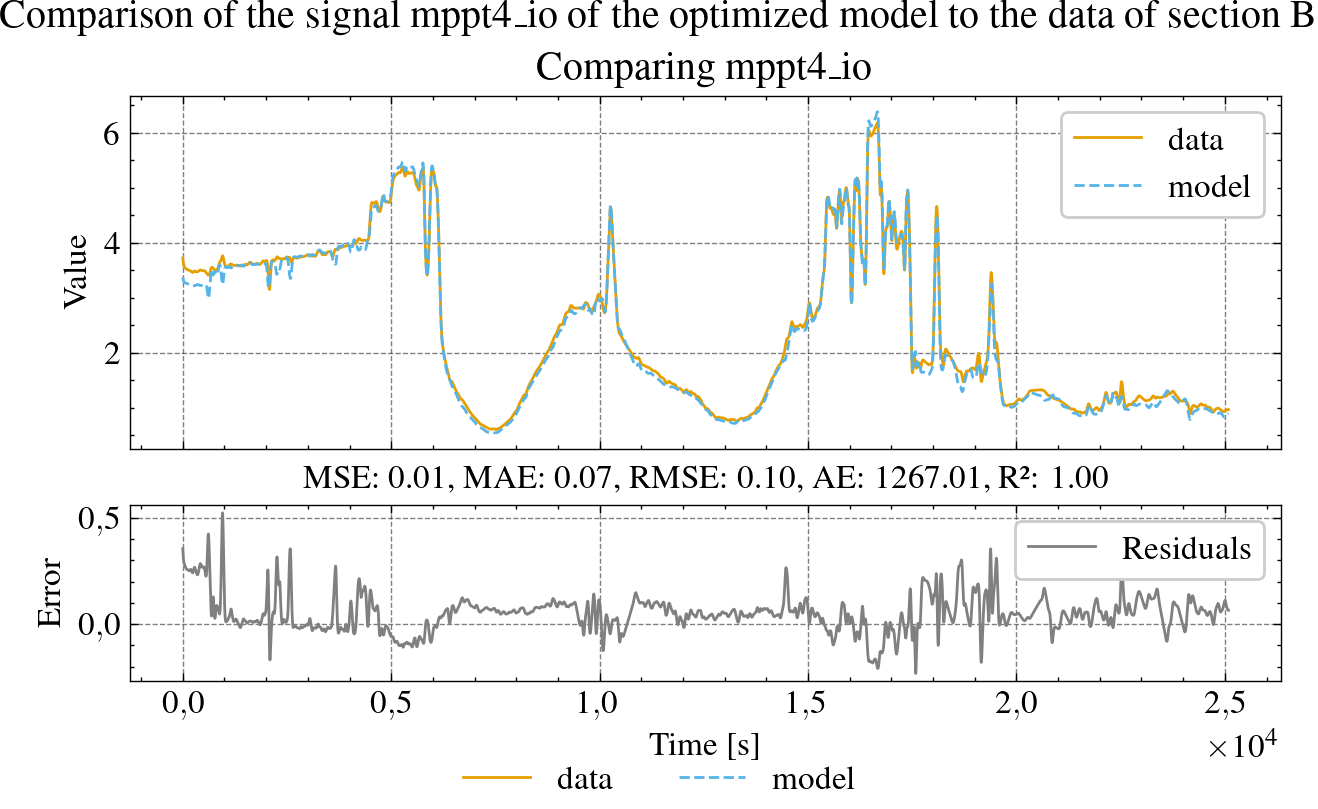

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_ii_test_b.pdf


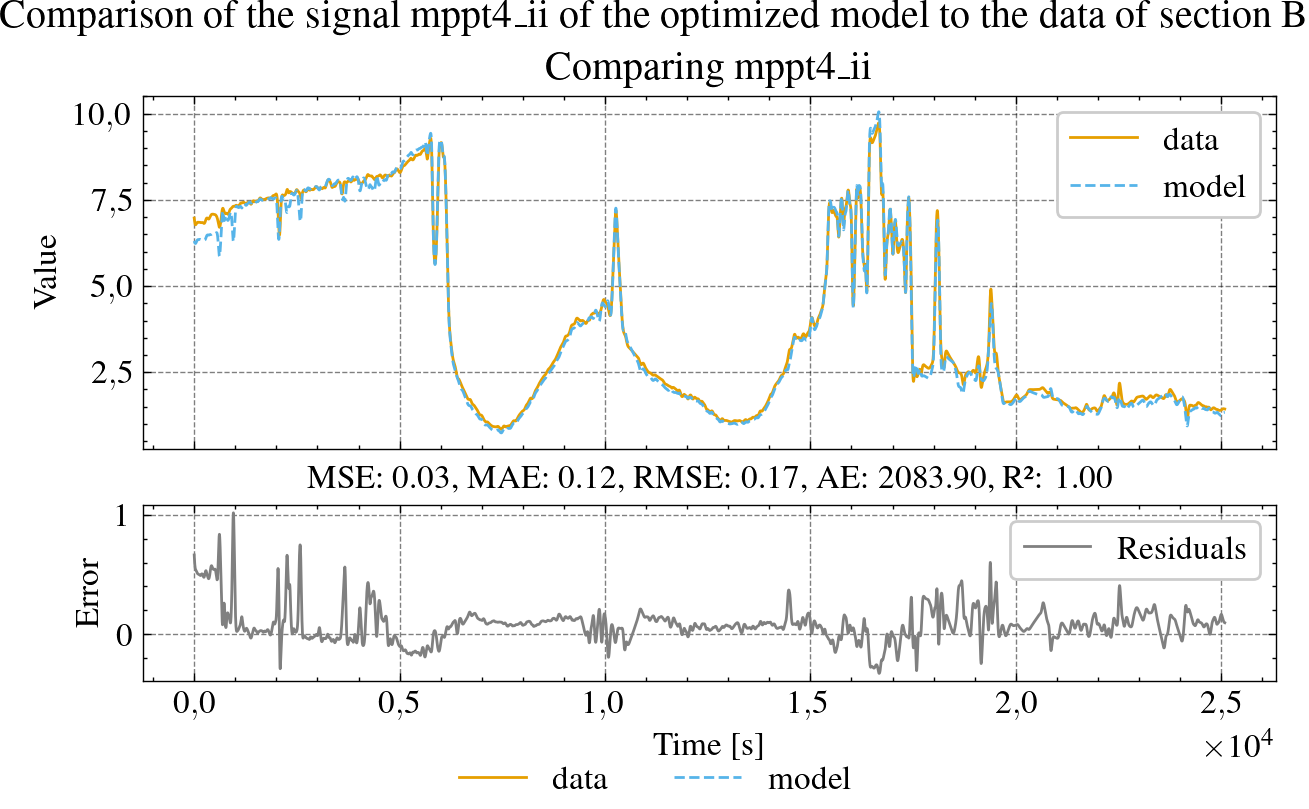

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_vi_test_b.pdf


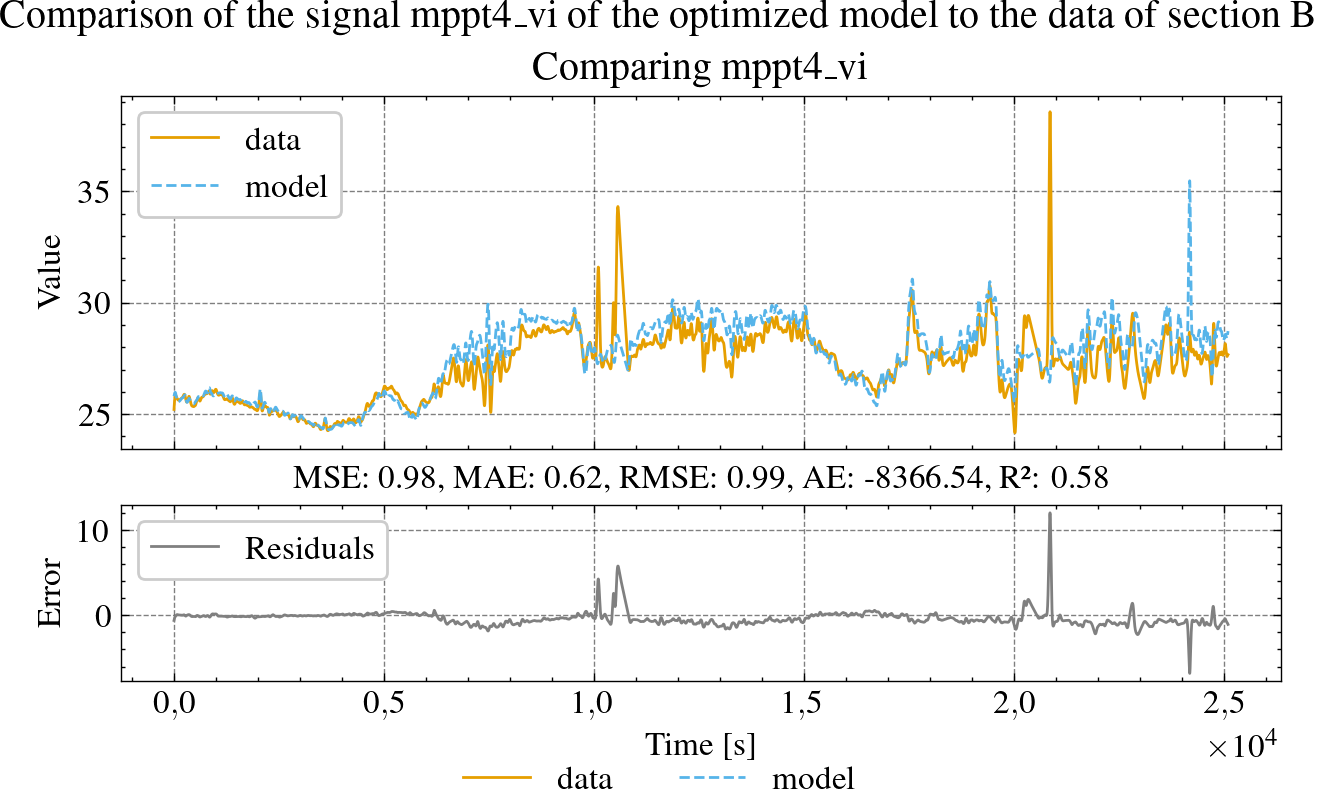

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_io_test_c.pdf


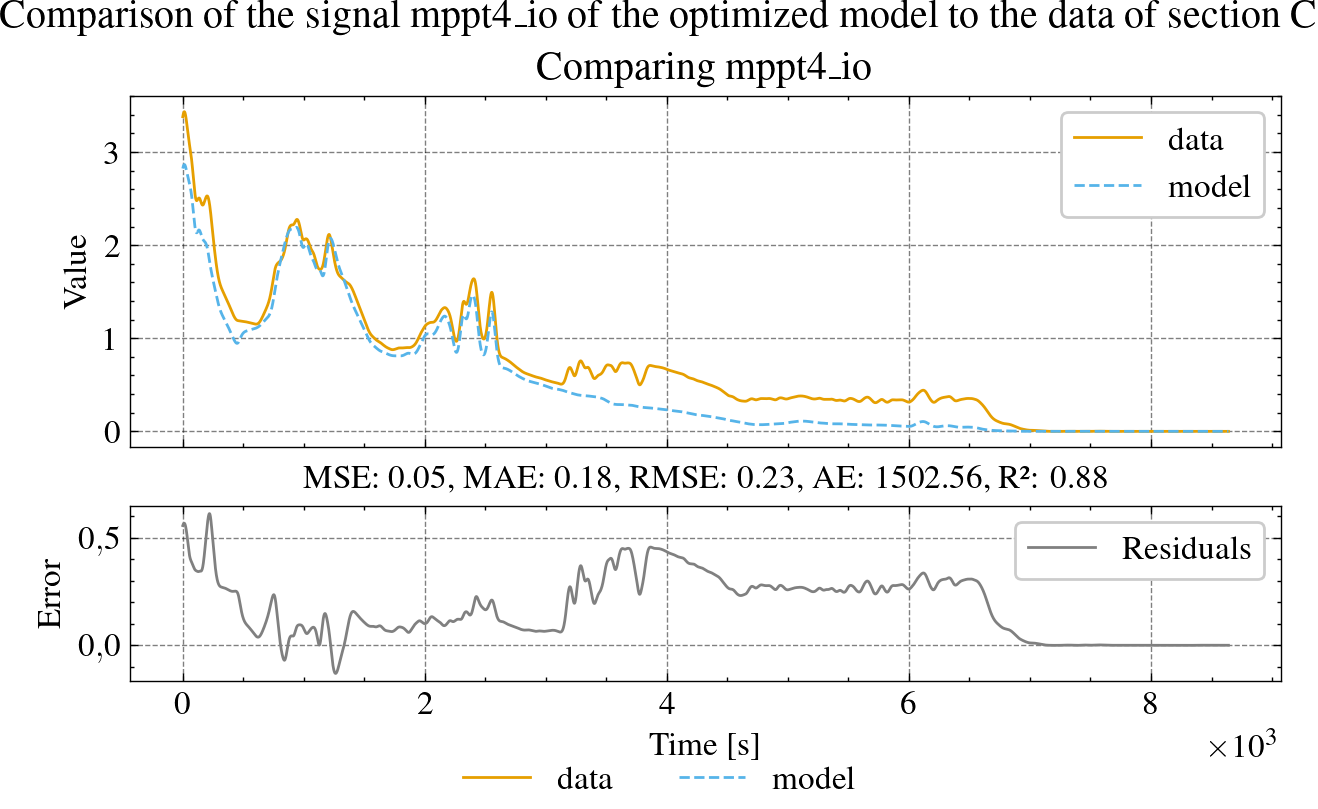

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_ii_test_c.pdf


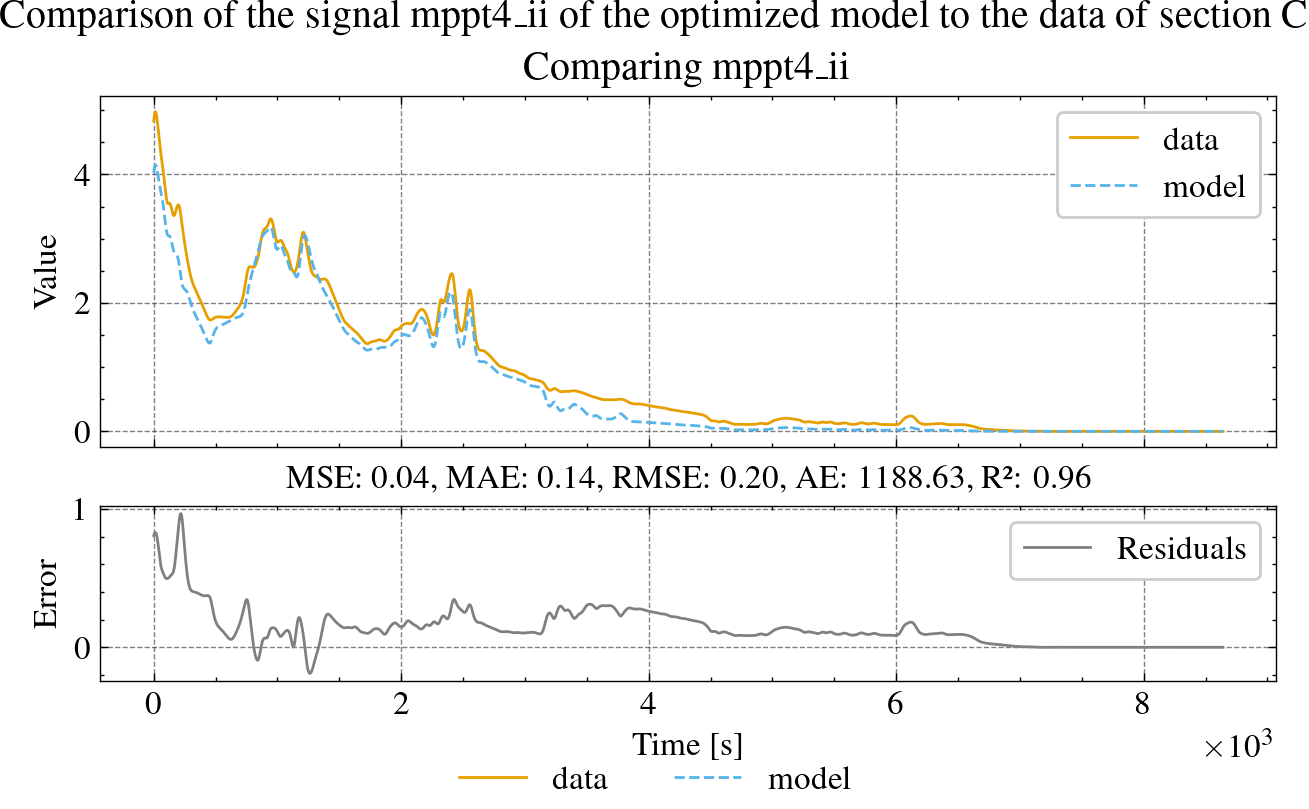

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_vi_test_c.pdf


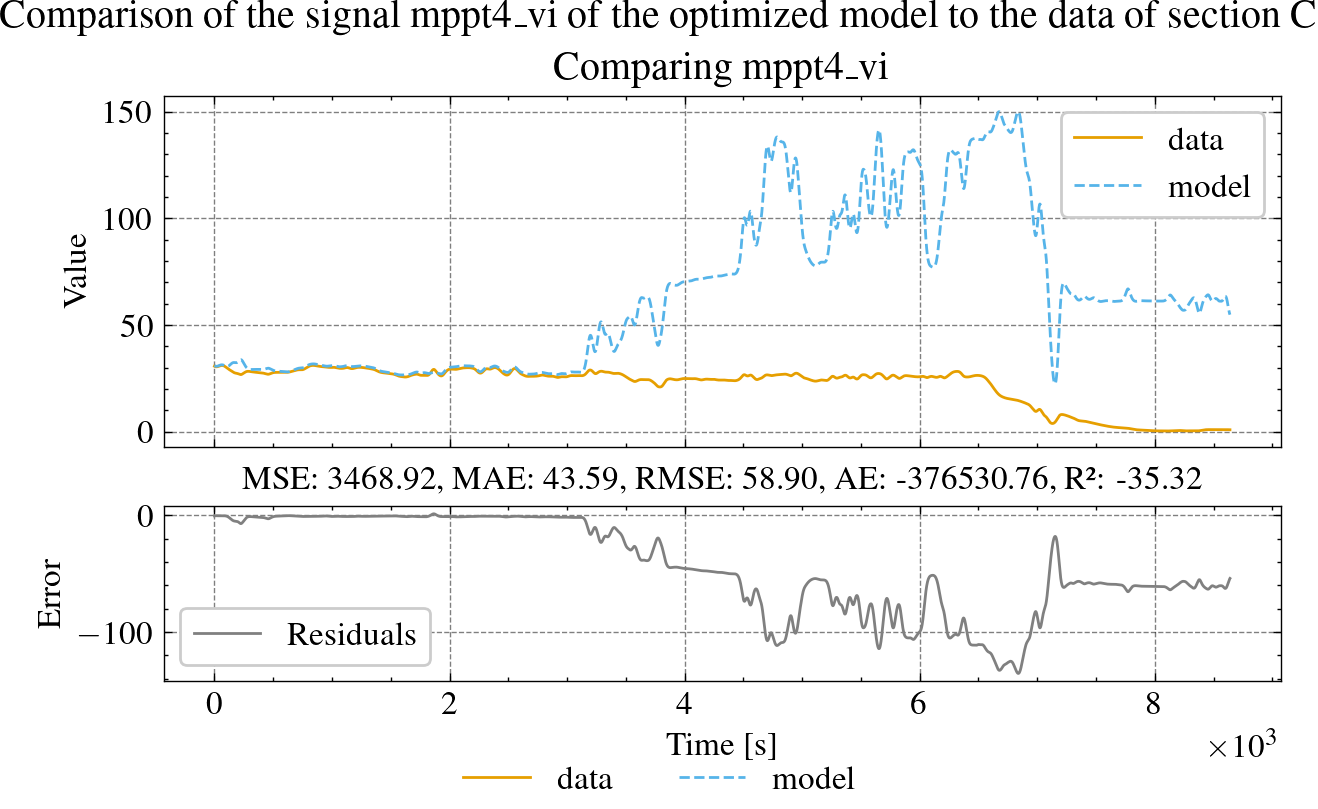

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_io_test_d.pdf


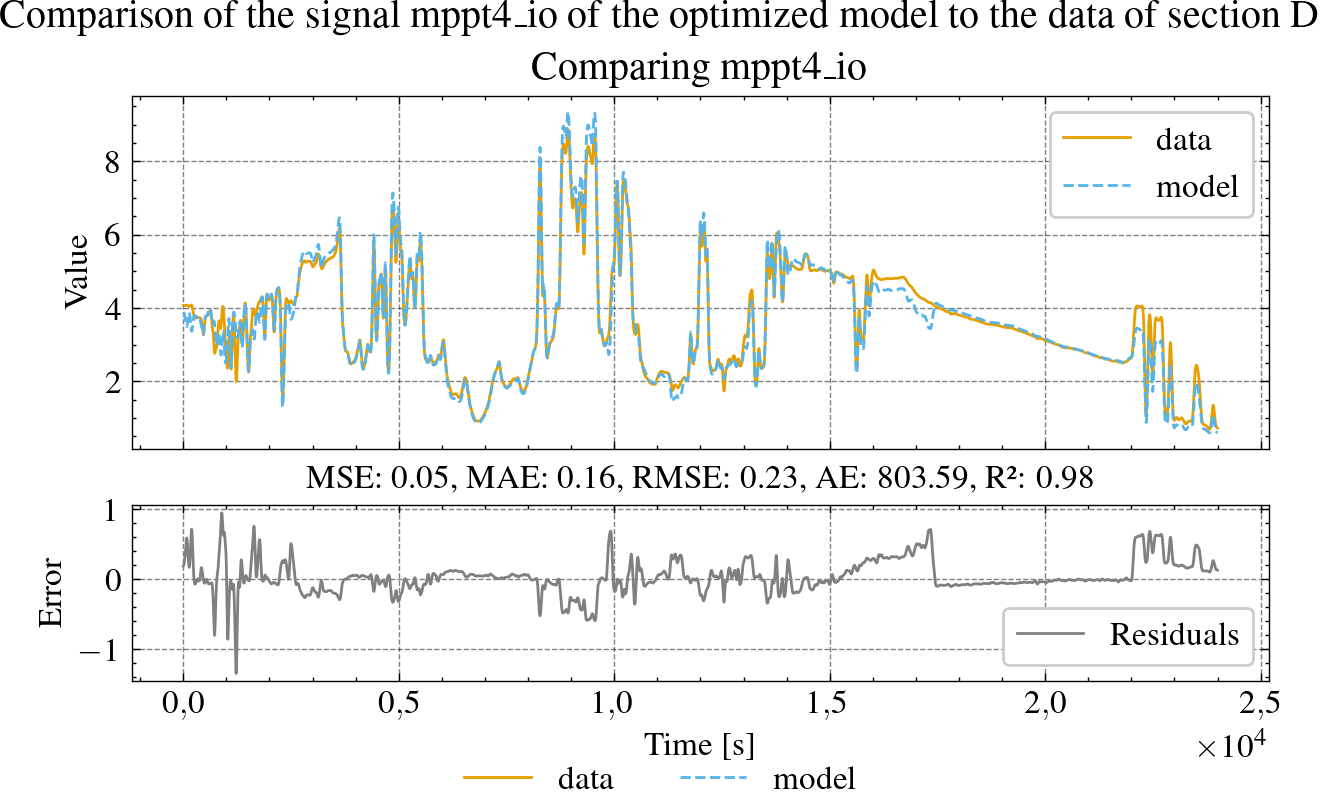

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_ii_test_d.pdf


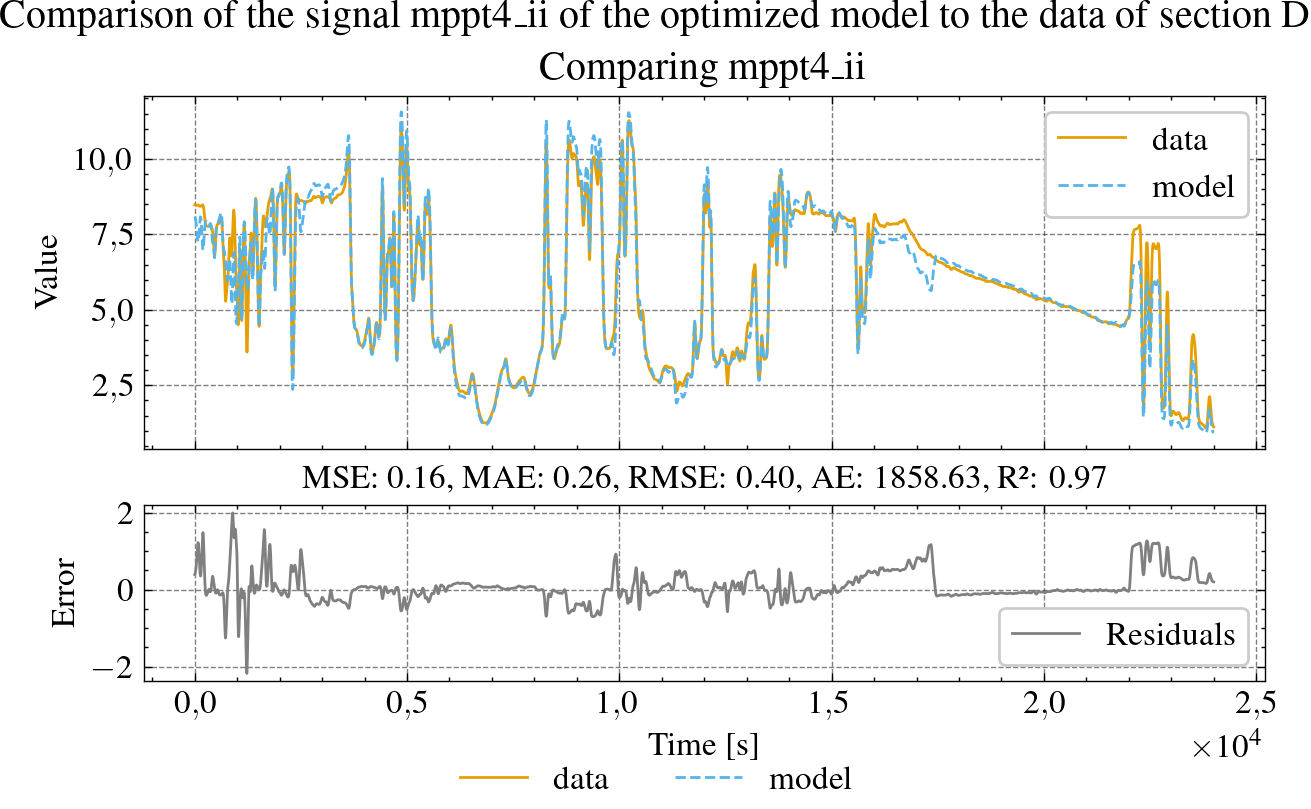

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_vi_test_d.pdf


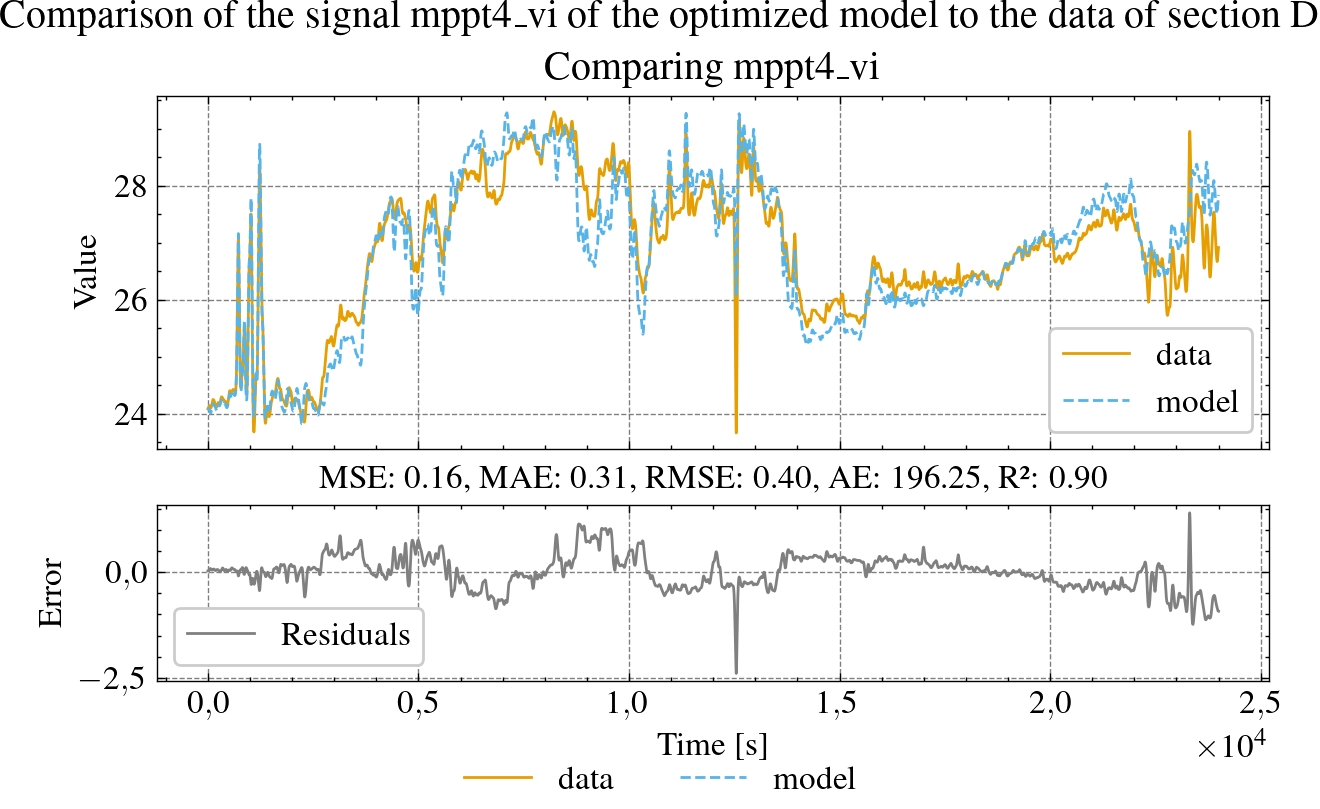

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_io_test_e.pdf


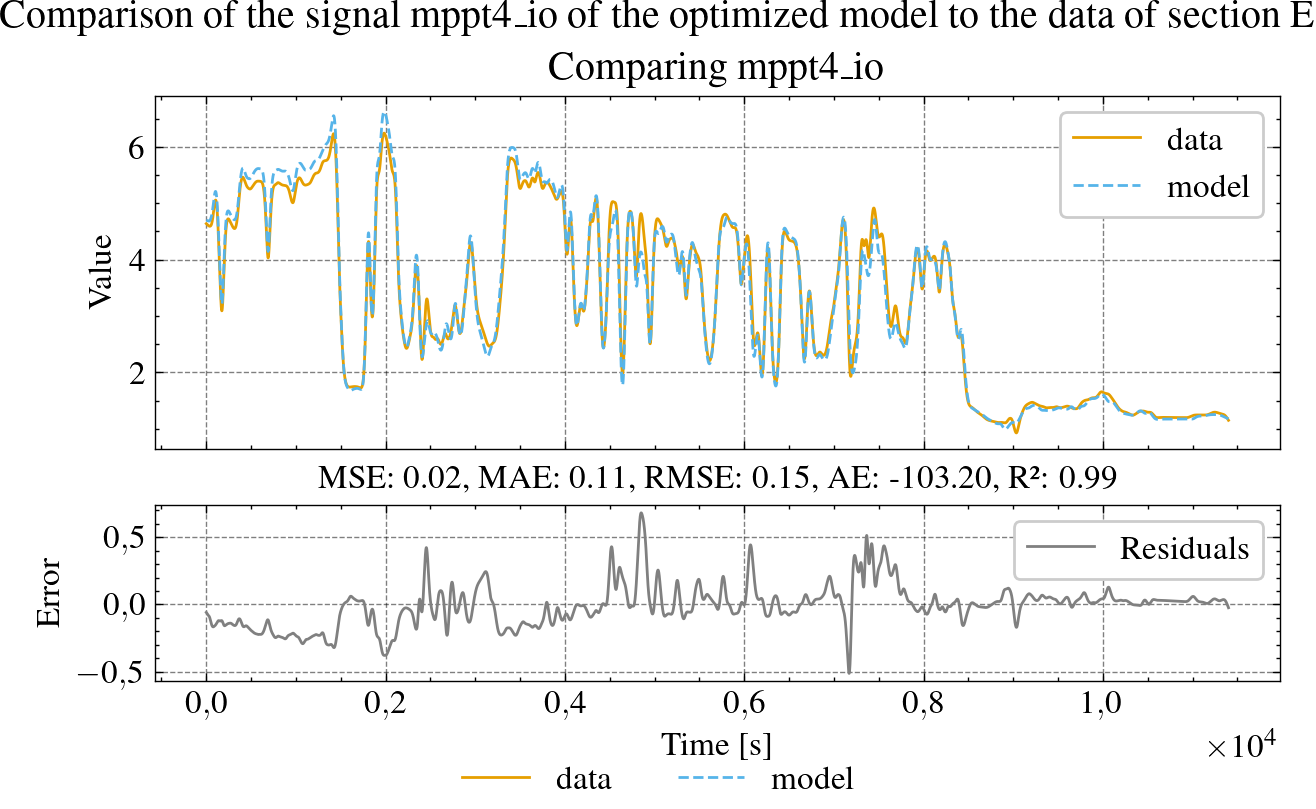

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_ii_test_e.pdf


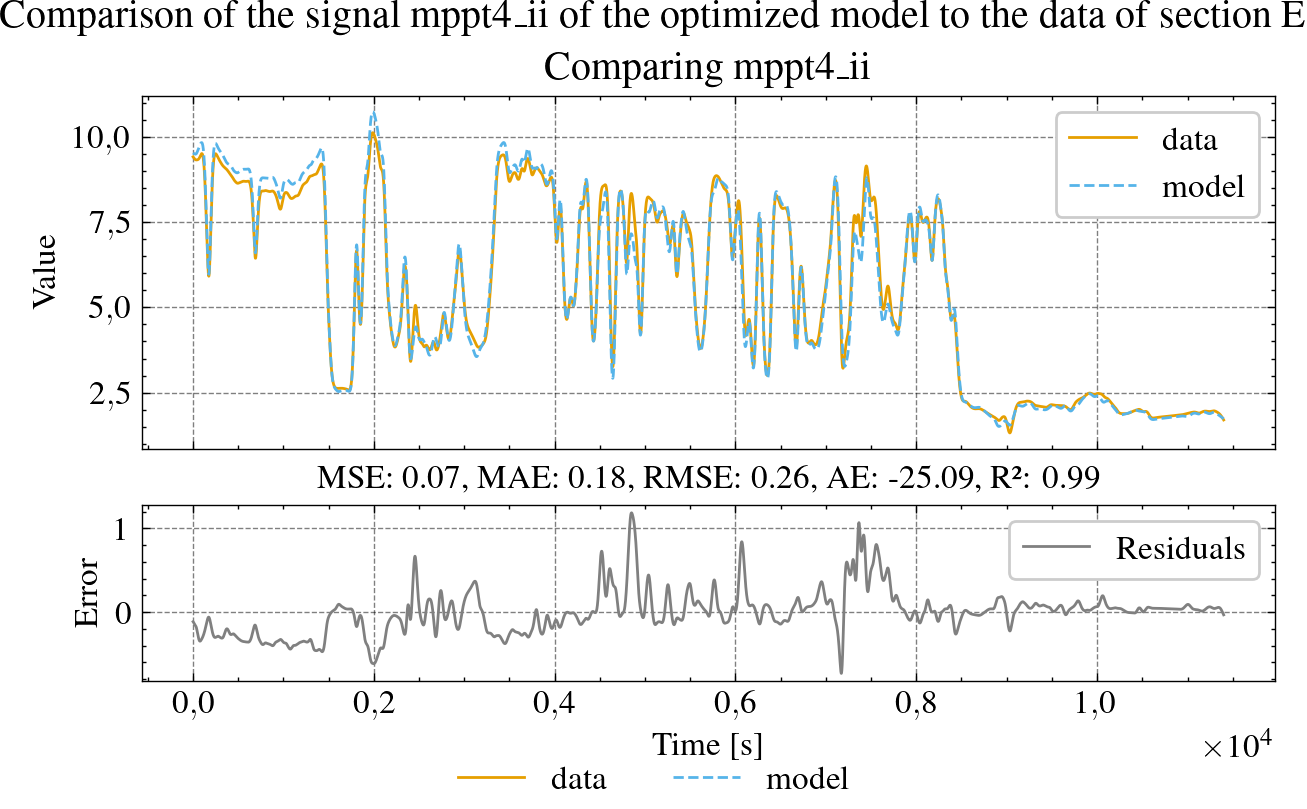

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_vi_test_e.pdf


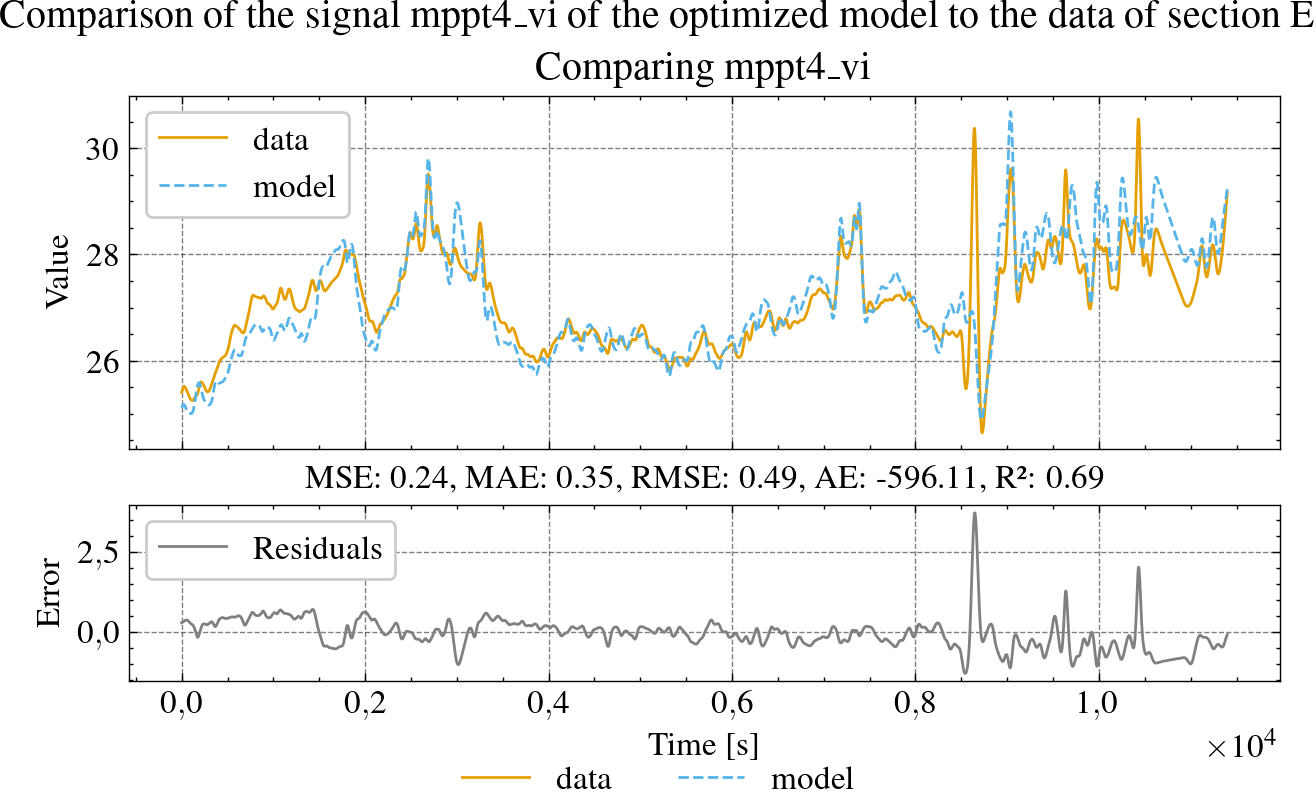

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_io_test_f.pdf


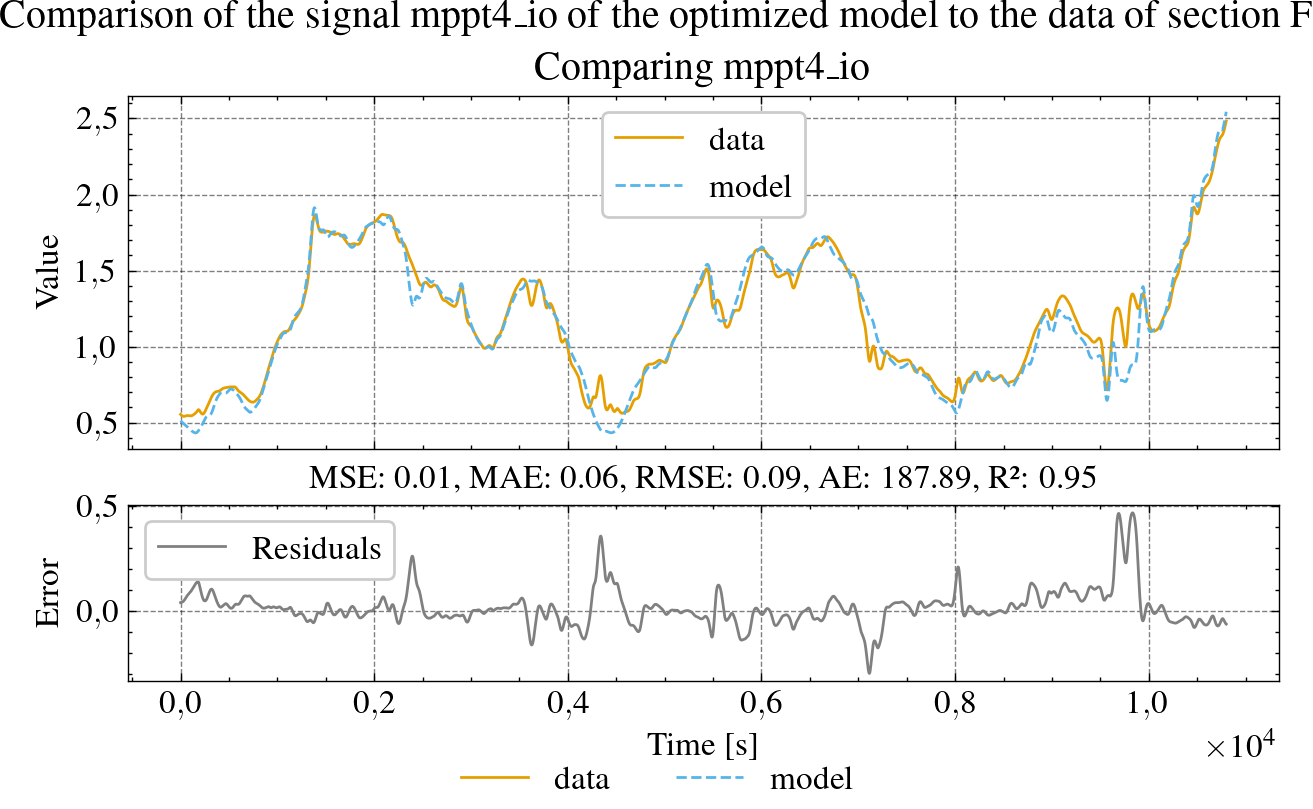

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_ii_test_f.pdf


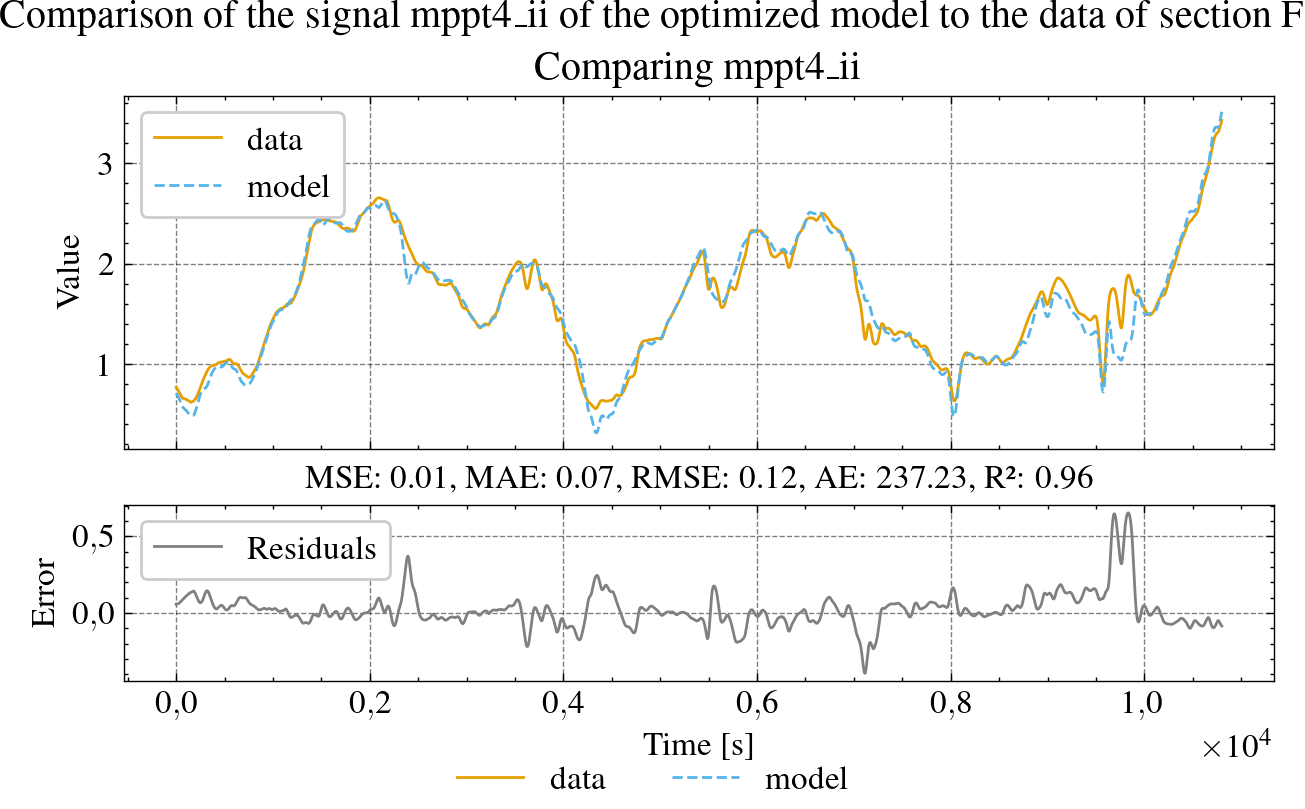

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//generation_optimization_test_residuals_mppt4_vi_test_f.pdf


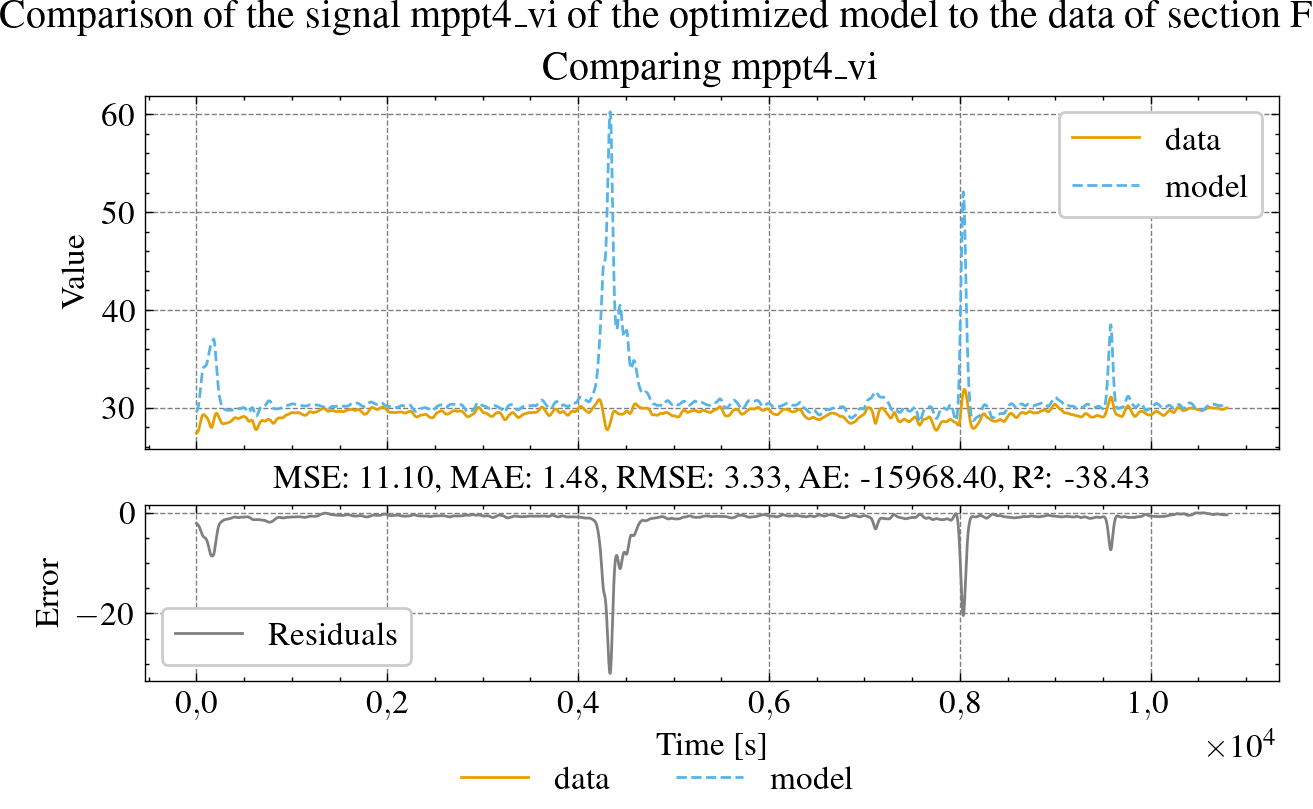

In [13]:
for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue

    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

    df_pred = model_function(T, U, X0, **(model_params | best_params))

    # Plot comparison for each data column
    for col in data_cols:
        filename = f'{latex_img_path}/generation_optimization_test_residuals_{col}_test_{section_name.lower()}.pdf'
        print(filename)
        fig_save_and_show(
            filename=filename,
            show_title=f'Comparison of the signal {col} of the optimized model to the data of section {section_name}',
            save_title=f'Comparação do sinal {col} do modelo otimizado com os dados da seção {section_name}',
            ncol=2,
            fig=plot_compare(df_test, df_pred, col, show=False),
        )


In [14]:
# Initialize a list to store metrics
metrics_list = []
for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    # Select the data and simulate
    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue

    # Simulate
    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

    df_pred = model_function(T, U, X0, **(generation_params | best_params))

    # Compute metrics for each data column
    for col in data_cols:
        metrics = compute_metrics(df_test[col].to_numpy(), df_pred[col].to_numpy())
        metrics['section'] = section_name
        metrics['data'] = col

        metrics_list.append(metrics)

# Create a DataFrame from the metrics list
df_metrics = pd.DataFrame(metrics_list).drop(columns=['residuals']).set_index(['section', 'data'])
display(df_metrics)

metrics_table_latex = df_metrics.to_latex(
    index=True,
    caption="Métricas de avaliação do modelo da Geração",
    label="table:generation_optimization_metrics_table",
    float_format="%.2f",
    column_format="l|l" + "|c" * (len(df_metrics.columns)),
    escape=True,
    decimal=',',
    position='h!',
    multicolumn=True,
).replace('\\toprule', '\\hline').replace('\\bottomrule\n', '').replace('\\midrule', '\\hline').replace('\\end{table}', '\\fonte{Elaboração Própria (\\the\\year)}\n\\end{table}')

with open(f"{latex_tex_path}/generation_optimization_metrics_table.tex", "w") as f:
    f.write(metrics_table_latex)

Ignoring section A  because of insufficient size


MSE        MAE       RMSE             AE         R2
section data                                                                 
B       mppt4_io     0.009735   0.074300   0.098668    1267.007501   0.995194
        mppt4_ii     0.028496   0.119958   0.168809    2083.895648   0.996105
        mppt4_vi     0.982855   0.617701   0.991391   -8366.536041   0.584343
C       mppt4_io     0.051050   0.176535   0.225943    1502.562400   0.883005
        mppt4_ii     0.039113   0.141304   0.197771    1188.625254   0.963367
        mppt4_vi  3468.919192  43.586687  58.897531 -376530.757836 -35.315725
D       mppt4_io     0.054777   0.157952   0.234045     803.587859   0.976218
        mppt4_ii     0.156271   0.255500   0.395311    1858.630326   0.972408
        mppt4_vi     0.161178   0.310197   0.401470     196.247500   0.895340
E       mppt4_io     0.023751   0.109150   0.154115    -103.203379   0.989647
        mppt4_ii     0.067837   0.179688   0.260455     -25.089199   0.990441
        mppt4_vi     0.240650   0.349341   0.490561    -596.108619   0.690917
F       mppt4_io     0.008043   0.056013   0.089685     187.888547   0.949226
        mppt4_ii     0.013879   0.074118   0.117809     237.227387   0.958516
        mppt4_vi    11.101449   1.478419   3.331884  -15968.402632 -38.428518